In [12]:
import pandas as pd
from IPython.display import clear_output
import numpy as np
import pymysql

from tqdm import tqdm
from ast import literal_eval


# Imports to increase the visibility of the apply function progress and the ability to run functions on multiple cpu cores.
from tqdm import tqdm
tqdm.pandas()
import multiprocessing
from functools import partial

# Core packages for text processing.

import string
import re
import matplotlib.pyplot as plt 


# Libraries for text preprocessing.
import nltk
from nltk.probability import FreqDist
import emoji
from collections import Counter

from nltk.corpus import stopwords
stopword_list = stopwords.words('dutch')


from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegressionCV
from nltk import ngrams


# More for wordclouds etc
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
from pprint import pprint
import itertools


# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold


import spacy
from spacy.tokenizer import Tokenizer
# from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.linear_model import LogisticRegressionCV
from nltk import ngrams

nlp = spacy.load("nl_core_news_md", exclude=['ner'])
# source NER from the same pipeline package as the last component
nlp.add_pipe("ner", source=spacy.load("nl_core_news_md"))

# insert the entity ruler
nlp.add_pipe("entity_ruler", before="ner")


import unicodedata

# Core packages for general use throughout the notebook.

import warnings
import random
import datetime as dt
from icecream import ic 
from datetime import date, timedelta   
from functools import reduce
from time import time
import os
from IPython.display import Audio
sound_file = './sound/beep.wav'
# Setting some options for general use.


import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

#Visualizations
import plotly.express as px


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

# Function to create the range for one week (given the start and end date)

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

# Dates are following format: Y-m-d
start_date = dt.datetime(2020, 12, 25)
start_date_date = dt.date(2021, 1, 1)
end_date = dt.datetime(2021, 5, 1)
end_date_date = dt.date(2021, 5, 1)
# print(end_date.month)

begindate_str = '2020-12-25'
enddate_str = '2021-05-01'
# clear_output()

In [13]:
# Some standard functions that are created by someone else and just need to be imported at the start.

def _df_split(tup_arg, **kwargs):
    split_ind, df_split, df_f_name = tup_arg
    return (split_ind, getattr(df_split, df_f_name)(**kwargs))

def df_multi_core(df, df_f_name, subset=None, njobs=-1, **kwargs):
    if njobs == -1:
        njobs = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=njobs)

    try:
        splits = np.array_split(df[subset], njobs)
    except ValueError:
        splits = np.array_split(df, njobs)

    pool_data = [(split_ind, df_split, df_f_name) for split_ind, df_split in enumerate(splits)]
    results = pool.map(partial(_df_split, **kwargs), pool_data)
    pool.close()
    pool.join()
    results = sorted(results, key=lambda x:x[0])
    results = pd.concat([split[1] for split in results])
    return results



<a id="Loading_the_Data"></a>
## Loading the Data

### **The tweets will be imported from the trollrensics database, based on three values: investigation, begin and end date.**

#### After loading the train and test data, I added "v"'s at the end of our variables for visualization because some of the pre-processing are not needed for the modelling but we can use them for our EDA part. Anyways let's look at our given data:

#### Well... We have keywords, locations, text and our target labels. We gonna use the text feature for our modelling here.

### [Back To Table of Contents](#top_section)

In [14]:
# Create a dataframe from the sql query
def create_dataframe(begindate, enddate, investigation):
    con = pymysql.connect(
        host='127.0.0.1', 
        user='user',
        password='password', 
        database='trollrensics')

    sql = f"""
      select p.platform, p.uniqueid, p.message, p.platform_created_at, p.topic_uniqueid, p.reply_uniqueid, p.share_uniqueid, p.like_cnt, p.reply_cnt, p.quote_cnt, p.share_cnt,
          p.trollrensics_metadata,
          pr.uniqueid AS profile_uniqueid, pr.username, pr.fullname, pr.followers_cnt, pr.following_cnt, pr.posts_cnt, pr.platform_metadata
      from posts p
      left join profiles pr on pr.id = p.profile_id
      left join investigation_post ip on ip.post_id = p.id
      left join investigations i on i.id = ip.investigation_id
      where p.platform_created_at > '{begindate}' and p.platform_created_at < '{enddate}'
        and i.slug in('{investigation}')
    """

    df = pd.read_sql(sql, con)
    df['Investigation'] = investigation
    print(df.shape)
    
    return df

In [15]:
frames = []

# begindate = '2021-01-01'
# enddate = '2021-06-01'
# investigation = 'druktebeeld-extra'
# frames.append(create_dataframe(begindate, enddate, investigation))

begindate = '2020-12-25'
enddate = '2021-06-01'

investigation = 'museumplein-druktebeeld'
frames.append(create_dataframe(begindate, enddate, investigation))

investigation = 'dedam-druktebeeld'
frames.append(create_dataframe(begindate, enddate, investigation))

investigation = 'vondelpark-druktebeeld'
frames.append(create_dataframe(begindate, enddate, investigation))


df = pd.concat(frames)
print(df.shape)
df.drop_duplicates(subset='uniqueid', inplace=True)
print(df.shape)

(59739, 20)
(16283, 20)
(16520, 20)
(92542, 20)
(90918, 20)


In [16]:
# Transform the date column to remove the time and only show dates
df['date'] = pd.to_datetime(df['platform_created_at']).dt.date

# df['platform_created_at'] = df['platform_created_at'].dt.strftime('%d/%m/%Y')

# Drop the columns that are not needed for this research based on following reasons:
# platform: Twitter is the only platform to be considered for this data
# trollresnsics_metadata & platform_metadata: both contain a lot of null-values and do not provide usefull information for this research
# username & fullname: This research does not need the account names, only the given unique id's. This way the project is also anonymized

df.drop(columns=['platform', 'platform_created_at', 'trollrensics_metadata', 'username', 'fullname', 'platform_metadata'], inplace=True)
df.rename(columns={"message": "text"}, inplace=True)
df.reset_index(drop=True, inplace=True)

df.info()
# df = df.loc[df['Investigation'] == LOCATION]

# df.to_csv('raw_tweets.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90918 entries, 0 to 90917
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniqueid          90918 non-null  object
 1   text              90918 non-null  object
 2   topic_uniqueid    90918 non-null  object
 3   reply_uniqueid    36793 non-null  object
 4   share_uniqueid    0 non-null      object
 5   like_cnt          90918 non-null  int64 
 6   reply_cnt         90918 non-null  int64 
 7   quote_cnt         90918 non-null  int64 
 8   share_cnt         90918 non-null  int64 
 9   profile_uniqueid  90918 non-null  object
 10  followers_cnt     90918 non-null  int64 
 11  following_cnt     90918 non-null  int64 
 12  posts_cnt         90918 non-null  int64 
 13  Investigation     90918 non-null  object
 14  date              90918 non-null  object
dtypes: int64(7), object(8)
memory usage: 10.4+ MB


<a id="Cleaning_Text"></a>
## Cleaning Text

#### Before the visualization of the text data I wanted to make it look better with some general helper functions to clear out things like: urls, hashtags, mentions and punctuations... We'll add all of them in one column called 'text_clean' then move from there for next steps. When we have cleaner text we can apply our tokenizer to split each word into a token. I'll apply this and next steps to individual columns to show each step of our progress. Next we transforming all words to lowercase then we remove stopwords (they don't mean much in sentence alone) so we use NLTK stopwords for it.

#### After removing these words we gonna lemmatize them but for that we need to add some extra steps to do it properly: We gonna apply part of speech tags to our text (like verb, noun etc.) then we convert them to wordnet format and finally we can apply lemmatizer and save it to 'lemmatized' column. And one last thing we convert these tokenized lists back to str version for future uses.

#### So basically what we did are:
- Removed urls, emojis, html tags and punctuations,
- Tokenized the tweet base texts,
- Lower cased clean text,
- Removed stopwords,
- Applied part of speech tags,
- Converted part of speeches to wordnet format,
- Applying word lemmatizer,
- Converted tokenized text to string again.


### [Back To Table of Contents](#top_section)

In [17]:
# Function that returns the lemmatized text, pos-tags and named entities for a tweet. 
def tweet_extraction(row):
    
    doc = nlp(row['clean_text'])
    
    spacy_text = []
    lemma = []
    pos = []
    for token in doc:
        if (token.is_alpha == True) and ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            spacy_text.append(token.text)
            lemma.append(token.lemma_)
            pos.append(token.pos_)

    row['spacy_text'] = spacy_text
    row['lemma'] = lemma
    row['pos'] = pos
    row['len_spacy_text'] = len(spacy_text)
    
    row['txt_bigram'] = [' '.join(grams) for grams in (ngrams(spacy_text, 2))]
    row['txt_trigram'] = [' '.join(grams) for grams in (ngrams(spacy_text, 3))]
    row['lemma_bigram'] = [' '.join(grams) for grams in (ngrams(lemma, 2))]
    row['lemma_trigram'] = [' '.join(grams) for grams in (ngrams(lemma, 3))]
    row['len_lemma'] = len(lemma) + len(row['lemma_bigram']) + len(row['lemma_trigram'])

#     All lists for the entities retrieved from the tweets
    dates = []
    organizations = []
    events = []
    persons = []
    time = []
    locations = []
    other_labels = []
    ents = [(e.text, e.label_) for e in doc.ents]
    for index,tuple in enumerate(ents):
        if tuple[1] == 'DATE':
            dates.append(tuple[0])
        elif tuple[1] == 'ORG':
            organizations.append(tuple[0])
        elif tuple[1] == 'LOC':
            locations.append(tuple[0])
        elif tuple[1] == 'TIME':
            time.append(tuple[0])
        elif tuple[1] == 'EVENT':
            events.append(tuple[0])
        elif tuple[1] == 'PERSON':
            persons.append(tuple[0])
        else:
            other_labels.append(tuple[0])
    row['ent_date'] = dates 
    row['ent_org'] = organizations 
    row['ent_event'] = events
    row['ent_person'] = persons
    row['ent_time'] = time
    row['ent_loc'] = locations
    row['ent_other'] = other_labels
    row['ent_len']  = len(dates) + len(organizations) + len(events) + len(persons) + len(time) + len(locations)
    
    return row


In [18]:
# None of the hashtags or mentions contain any puntuations, yet they can be at the end of a line and a point, comma, question mark, etc could be added to the hashtag/mention as the sentence is split on spaces. Therefore this function to filter that out. 
def make_hashtag_nice(tag):
    table = str.maketrans('x', 'x', string.punctuation)
    clean_text = tag.translate(table)
    new_clean = clean_text.replace("\n", ' ')
    clean = new_clean.split(' ')
    clean = clean[0].lower()

    return clean


In [20]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def clean_all(row):
    text = row['text']
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    mentions = []
    hashtags = []

    words = text.split(' ')
#     Removing tweets smaller then 3 words

    for word in words:
        if word.startswith('@'):
            cleaned = make_hashtag_nice(word)
            mentions.append(cleaned)
        elif word.startswith('#'):
            cleaned = make_hashtag_nice(word)
            hashtags.append(cleaned)
#     Removing spaces if there is more than 1
    no_spaces = re.sub(' +', ' ',text)
#     Removing any emoji's, could look into adding this as vector as well (amount of happy/sad/angry emoji's, like entities or something)
    emoji_list = [c for c in no_spaces if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in no_spaces.split() if not any(i in str for i in emoji_list)])
#     Removing the URLs from the text
    removed_urls_text = re.sub(r'http\S+', '', clean_text)
#     Removing punctuation from the text
    row['clean_text'] = removed_urls_text.translate(str.maketrans('', '', string.punctuation))
#     Call function for spacy model to retrieve needed information
    row = tweet_extraction(row)

#     Add the mentions and hashtags which have been retrieved above to the row as separate columns also with the amount of hashtags (which might be used later?)
    row['mentions'] = mentions
    row['hashtags'] = hashtags
    row['len_mentions'] = len(mentions)
    row['len_hashtags'] = len(hashtags)
    row['all_len'] = row['len_mentions'] + row['len_hashtags'] + row['ent_len'] + row['len_lemma']
    return row


df_text = df_multi_core(df=df, df_f_name='progress_apply', subset=['uniqueid','text'],njobs=-1, func=clean_all, axis=1)
# df_text = df_test.apply(clean_all, axis=1)
print('DONE')

100%|██████████| 11365/11365 [10:55<00:00, 17.34it/s]


DONE


In [ ]:
# Overzichtje maken van de woorden die in spam tweets voorkomen
spam_df = df_text.loc[df_text['len_lemma'] < 4]


In [11]:
only_large_df = df_text.loc[df_text['len_lemma'] > 3]
only_large_df

uniqueid                                               text                                         clean_text                                         spacy_text                                              lemma                                                pos  len_spacy_text  len_lemma                                         txt_bigram                                        txt_trigram                                       lemma_bigram                                      lemma_trigram              ent_date         ent_org ent_event                                         ent_person   ent_time                   ent_loc                                          ent_other                                           mentions                                           hashtags  len_mentions  len_hashtags
0      1376795456186032128  @RHvL88 Het is maar een stief kwartiertje lope...  RHvL88 Het is maar een stief kwartiertje lopen...    [stief, kwartiertje, lopen, Rokin, Museumplein]       [stief, kwartier, lopen, rokin, museumplein]                   [NOUN, NOUN, VERB, PROPN, PROPN]               5          5  [stief kwartiertje, kwartiertje lopen, lopen R...  [stief kwartiertje lopen, kwartiertje lopen Ro...  [stief kwartier, kwartier lopen, lopen rokin, ...  [stief kwartier lopen, kwartier lopen rokin, l...                    []              []        []                                                 []         []                   [Rokin]                                           [RHvL88]                                           [rhvl88]                                                 []             1             0
1      1376793687477391361  Amsterdam | #Grachtengordel  #wanddecoratie\n1...  Amsterdam  Grachtengordel wanddecoratie 10 Len...  [Amsterdam, Grachtengordel, wanddecoratie, Len...  [amsterdam, grachtengordel, wanddecoratie, len...  [PROPN, NOUN, NOUN, NOUN, NOUN, ADP, PROPN, PR...              35         35  [Amsterdam Grachtengordel, Grachtengordel wand...  [Amsterdam Grachtengordel wanddecoratie, Grach...  [amsterdam grachtengordel, grachtengordel wand...  [amsterdam grachtengordel wanddecoratie, grach...        [5 april 2021]              []        []                                                 []         []                        []  [Amsterdam, 10, Lentekorting, Amsterdam, Mokum...                                                 []  [grachtengordel, wanddecoratie, lentekorting, ...             0            17
2      1376801305084198914  @AT5 het museumplein is een hele leuke lokatie...  AT5 het museumplein is een hele leuke lokatie ...  [museumplein, leuke, lokatie, feesten, koffie,...  [museumplein, leuk, lokatie, feest, koffie, dr...                [NOUN, ADJ, NOUN, NOUN, NOUN, VERB]               6          6  [museumplein leuke, leuke lokatie, lokatie fee...  [museumplein leuke lokatie, leuke lokatie fees...  [museumplein leuk, leuk lokatie, lokatie feest...  [museumplein leuk lokatie, leuk lokatie feest,...                    []              []        []                                                 []         []                        []                                                 []                                              [at5]                                                 []             1             0
3      1376800177332314113  @rivliv NL leuk oefenveld: vreedzame burgers d...  rivliv NL leuk oefenveld vreedzame burgers daa...  [rivliv, NL, leuk, oefenveld, vreedzame, burge...  [rivliv, nl, leuk, oefenveld, vreedzaam, burge...  [NOUN, PROPN, ADJ, VERB, ADJ, NOUN, VERB, VERB...              25         25  [rivliv NL, NL leuk, leuk oefenveld, oefenveld...  [rivliv NL leuk, NL leuk oefenveld, leuk oefen...  [rivliv nl, nl leuk, leuk oefenveld, oefenveld...  [rivliv nl leuk, nl leuk oefenveld, leuk oefen...                    []              []        []                                             [Kijk]         []                        []                               [rivliv, NL, Romeos

In [12]:
# Merg the new dataframe with the old one to keep some of the stats like like count, reply count etc etc

total_df = df.merge(only_large_df, how='inner', left_on='uniqueid', right_on='uniqueid')
total_df.drop(columns=['text_x', 'text_y', 'topic_uniqueid', 'reply_uniqueid', 'share_uniqueid'], inplace=True)

total_df

uniqueid  like_cnt  reply_cnt  quote_cnt  share_cnt     profile_uniqueid  followers_cnt  following_cnt  posts_cnt            Investigation        date                                         clean_text                                         spacy_text                                              lemma                                                pos  len_spacy_text  len_lemma                                         txt_bigram                                        txt_trigram                                       lemma_bigram                                      lemma_trigram              ent_date         ent_org ent_event                                         ent_person   ent_time                   ent_loc                                          ent_other                                           mentions                                           hashtags  len_mentions  len_hashtags
0      1376795456186032128         1          0          0          0             36447473          30272           1749     214525  museumplein-druktebeeld  2021-03-30  RHvL88 Het is maar een stief kwartiertje lopen...    [stief, kwartiertje, lopen, Rokin, Museumplein]       [stief, kwartier, lopen, rokin, museumplein]                   [NOUN, NOUN, VERB, PROPN, PROPN]               5          5  [stief kwartiertje, kwartiertje lopen, lopen R...  [stief kwartiertje lopen, kwartiertje lopen Ro...  [stief kwartier, kwartier lopen, lopen rokin, ...  [stief kwartier lopen, kwartier lopen rokin, l...                    []              []        []                                                 []         []                   [Rokin]                                           [RHvL88]                                           [rhvl88]                                                 []             1             0
1      1376793687477391361         0          0          0          0   816668454950490112             89            192        999  museumplein-druktebeeld  2021-03-30  Amsterdam  Grachtengordel wanddecoratie 10 Len...  [Amsterdam, Grachtengordel, wanddecoratie, Len...  [amsterdam, grachtengordel, wanddecoratie, len...  [PROPN, NOUN, NOUN, NOUN, NOUN, ADP, PROPN, PR...              35         35  [Amsterdam Grachtengordel, Grachtengordel wand...  [Amsterdam Grachtengordel wanddecoratie, Grach...  [amsterdam grachtengordel, grachtengordel wand...  [amsterdam grachtengordel wanddecoratie, grach...        [5 april 2021]              []        []                                                 []         []                        []  [Amsterdam, 10, Lentekorting, Amsterdam, Mokum...                                                 []  [grachtengordel, wanddecoratie, lentekorting, ...             0            17
2      1376801305084198914         1          0          0          0            227119302             39             30       1901  museumplein-druktebeeld  2021-03-30  AT5 het museumplein is een hele leuke lokatie ...  [museumplein, leuke, lokatie, feesten, koffie,...  [museumplein, leuk, lokatie, feest, koffie, dr...                [NOUN, ADJ, NOUN, NOUN, NOUN, VERB]               6          6  [museumplein leuke, leuke lokatie, lokatie fee...  [museumplein leuke lokatie, leuke lokatie fees...  [museumplein leuk, leuk lokatie, lokatie feest...  [museumplein leuk lokatie, leuk lokatie feest,...                    []              []        []                                                 []         []                        []                                                 []                                              [at5]                                                 []             1             0
3      1376800177332314113         0          0          0          1           2914267607            867           1484       4375  museumplein-druktebeeld  2021-03-30  rivliv NL leuk oefenveld vreedzame burgers daa...  [rivliv, NL, leuk, oefenveld, vreedzame, burge...  [rivliv, nl, leuk, oefenveld, vreedzaam, burge...  [NOUN, PROP

In [13]:
# Remove the tweets that have the same text and are posted on the same day to prevent some spam messages.

mask = total_df.duplicated(subset=['clean_text', 'date'],keep=False)
print(mask.value_counts())

total_df.drop_duplicates(subset=['clean_text', 'date'],keep='first', inplace=True)
total_df = total_df.reset_index(drop=True)
total_df

False    79148
True      4406
dtype: int64


uniqueid  like_cnt  reply_cnt  quote_cnt  share_cnt     profile_uniqueid  followers_cnt  following_cnt  posts_cnt            Investigation        date                                         clean_text                                         spacy_text                                              lemma                                                pos  len_spacy_text  len_lemma                                         txt_bigram                                        txt_trigram                                       lemma_bigram                                      lemma_trigram              ent_date         ent_org ent_event                                         ent_person   ent_time                   ent_loc                                          ent_other                                           mentions                                           hashtags  len_mentions  len_hashtags
0      1376795456186032128         1          0          0          0             36447473          30272           1749     214525  museumplein-druktebeeld  2021-03-30  RHvL88 Het is maar een stief kwartiertje lopen...    [stief, kwartiertje, lopen, Rokin, Museumplein]       [stief, kwartier, lopen, rokin, museumplein]                   [NOUN, NOUN, VERB, PROPN, PROPN]               5          5  [stief kwartiertje, kwartiertje lopen, lopen R...  [stief kwartiertje lopen, kwartiertje lopen Ro...  [stief kwartier, kwartier lopen, lopen rokin, ...  [stief kwartier lopen, kwartier lopen rokin, l...                    []              []        []                                                 []         []                   [Rokin]                                           [RHvL88]                                           [rhvl88]                                                 []             1             0
1      1376793687477391361         0          0          0          0   816668454950490112             89            192        999  museumplein-druktebeeld  2021-03-30  Amsterdam  Grachtengordel wanddecoratie 10 Len...  [Amsterdam, Grachtengordel, wanddecoratie, Len...  [amsterdam, grachtengordel, wanddecoratie, len...  [PROPN, NOUN, NOUN, NOUN, NOUN, ADP, PROPN, PR...              35         35  [Amsterdam Grachtengordel, Grachtengordel wand...  [Amsterdam Grachtengordel wanddecoratie, Grach...  [amsterdam grachtengordel, grachtengordel wand...  [amsterdam grachtengordel wanddecoratie, grach...        [5 april 2021]              []        []                                                 []         []                        []  [Amsterdam, 10, Lentekorting, Amsterdam, Mokum...                                                 []  [grachtengordel, wanddecoratie, lentekorting, ...             0            17
2      1376801305084198914         1          0          0          0            227119302             39             30       1901  museumplein-druktebeeld  2021-03-30  AT5 het museumplein is een hele leuke lokatie ...  [museumplein, leuke, lokatie, feesten, koffie,...  [museumplein, leuk, lokatie, feest, koffie, dr...                [NOUN, ADJ, NOUN, NOUN, NOUN, VERB]               6          6  [museumplein leuke, leuke lokatie, lokatie fee...  [museumplein leuke lokatie, leuke lokatie fees...  [museumplein leuk, leuk lokatie, lokatie feest...  [museumplein leuk lokatie, leuk lokatie feest,...                    []              []        []                                                 []         []                        []                                                 []                                              [at5]                                                 []             1             0
3      1376800177332314113         0          0          0          1           2914267607            867           1484       4375  museumplein-druktebeeld  2021-03-30  rivliv NL leuk oefenveld vreedzame burgers daa...  [rivliv, NL, leuk, oefenveld, vreedzame, burge...  [rivliv, nl, leuk, oefenveld, vreedzaam, burge...  [NOUN, PROP

In [14]:
# Split the dataframes into 90% for training (80%) plus validation (10%) purposes and 10% for testing. This last 10% is calculated to be the last month of this project (june) and will never be seen by the model until the end.

# mask = total_df['date'] <= dt.date(2021,5,1)
# trainv = total_df.loc[mask]
# testv = total_df.drop(trainv.index)

# trainv.reset_index(drop=True)
# testv.reset_index(drop=True)
# print(total_df.shape)
# print(trainv.shape)
# print(testv.shape)

<IPython.core.display.Javascript object>

(80278, 32)
(73481, 32)
(6797, 32)



<a id="Loading_the_Data"></a>
# Import the crowdedness data

### **The tweets will be imported from the trollrensics database, based on three values: investigation, begin and end date.**

Investigation indicates the location of the tweets that are gathered. Those locations are: Dam square, Vondelpark and Museum Sqaure.


### [Back To Table of Contents](#top_section)


In [1]:
# Read  dataframe created above. It is saved as new dataframe, not to overwrite the original one and therefore not needed to rerun all if something went wrong.

tweet_df = total_df

tweet_df.loc[tweet_df['Investigation'] == 'museumplein-druktebeeld', 'Investigation'] = 'Museumplein'
tweet_df.loc[tweet_df['Investigation'] == 'dedam-druktebeeld', 'Investigation'] = 'DeDam'
tweet_df.loc[tweet_df['Investigation'] == 'vondelpark-druktebeeld', 'Investigation'] = 'Vondelpark'

tweet_df.rename(columns={'Investigation': 'Location'}, inplace=True)
tweet_df

NameError: name 'total_df' is not defined

In [7]:
tweet_df = pickle.load(open("tweet_df_klein2.pkl", "rb"))


<IPython.core.display.Javascript object>

In [8]:
# Loading the resono data to indicate the crowdedness for certain areas at certain days. 
# For this research, the max number of people per day has been taken to give the best indication whether there has been a large crowd that day.

location_import_df = pd.read_csv('resono_numbers.csv', header=0)
location_import_df['date'] = pd.to_datetime(location_import_df['datetime']).dt.date

# Group by location and date and pick the highest amount of people from 1 day
vondel_df = location_import_df[['date', 'Vondelpark West']]
museumplein_df = location_import_df[['date', 'Museumplein']]
dam_df = location_import_df[['date', 'De Dam West']]

# Rename some of the columns from the crowdedness data source
vondel_df.rename(columns={'Vondelpark West': 'Location'}, inplace=True)
museumplein_df.rename(columns={'Museumplein': 'Location'}, inplace=True)
dam_df.rename(columns={'De Dam West': 'Location'}, inplace=True)

vondel_grp_df = vondel_df.groupby('date').max().reset_index()
museumplein_grp_df = museumplein_df.groupby('date').max().reset_index()
dam_grp_df = dam_df.groupby('date').max().reset_index()



In [9]:
# Make Combine Dataframe of all the locations

all_locs_df = pd.DataFrame()
all_locs_df['date'] = vondel_grp_df['date']
all_locs_df['Vondelpark'] = vondel_grp_df['Location']
all_locs_df['Museumplein'] = museumplein_grp_df['Location']
all_locs_df['DeDam'] = dam_grp_df['Location']

all_locs_df.tail()

date  Vondelpark  Museumplein   DeDam
275  2021-07-08       449.0        353.0   855.0
276  2021-07-11       676.0        662.0  1760.0
277  2021-07-12       392.0        444.0  1101.0
278  2021-07-13       825.0        688.0  1504.0
279  2021-07-14       751.0        689.0   860.0

In [13]:
# Make the resono threshold. This threshold is created by the city of Amsterdam.

threshold_df = pd.read_csv('resono_threshold.csv',header=0,index_col=0, dtype={'crowd_threshold_low': int,'crowd_threshold_high':int})
threshold_df.drop(columns='area_m2', inplace=True)

mp_thresh = threshold_df.loc[threshold_df['location'] == 'Museumplein'].values[0]
dam_thresh = threshold_df.loc[threshold_df['location'] == 'De Dam West'].values[0]
vondel_thresh = threshold_df.loc[threshold_df['location'] == 'Vondelpark West'].values[0]


mp_thresh

array(['Museumplein', 334, 501], dtype=object)

In [19]:
# In the block, all the locations get a crowdedness indication based on the assigned thresholds. This is the eventual category the model will be trained on to predict in the future.

all_locs_df['Vondelpark_crowded'] = 0
all_locs_df['Museumplein_crowded'] = 0
all_locs_df['DeDam_crowded'] = 0 

# This threshold is self chosen and more of an indicator for an 'event'. It is assigned the event category if the high threshold is DOUBLED for that day.
# all_locs_df.loc[all_locs_df['Vondelpark'] > vondel_thresh[2]*2, 'Vondelpark_crowded'] = 1
all_locs_df.loc[all_locs_df['Vondelpark'] > 1000, 'Vondelpark_crowded'] = 1
# all_locs_df.loc[all_locs_df['Museumplein'] > mp_thresh[2]*2, 'Museumplein_crowded'] = 1
all_locs_df.loc[all_locs_df['Museumplein'] > 1000, 'Museumplein_crowded'] = 1
all_locs_df.loc[all_locs_df['DeDam'] > 900, 'DeDam_crowded'] = 1
# all_locs_df.loc[all_locs_df['DeDam'] > dam_thresh[2]*2, 'DeDam_crowded'] = 1

# Old technique of assigning the 'events'
# all_locs_df.loc[all_locs_df['Vondelpark'].nlargest(5).index, 'Vondelpark_crowded'] = 3
# all_locs_df.loc[all_locs_df['Museumplein'].nlargest(5).index, 'Museumplein_crowded'] = 3
# all_locs_df.loc[all_locs_df['DeDam'].nlargest(5).index, 'DeDam_crowded'] = 3

all_locs_df.tail()

date  Vondelpark  Museumplein   DeDam  Vondelpark_crowded  Museumplein_crowded  DeDam_crowded
275  2021-07-08       449.0        353.0   855.0                   0                    0              0
276  2021-07-11       676.0        662.0  1760.0                   0                    0              1
277  2021-07-12       392.0        444.0  1101.0                   0                    0              1
278  2021-07-13       825.0        688.0  1504.0                   0                    0              1
279  2021-07-14       751.0        689.0   860.0                   0                    0              0

In [20]:
plot_df = all_locs_df.loc[all_locs_df['date'] > start_date_date]

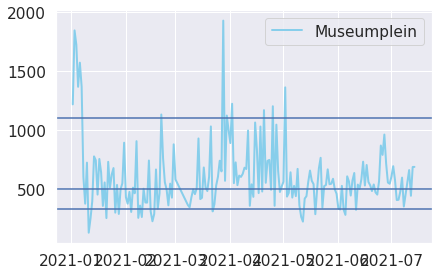

In [21]:
# multiple line plots
plt.plot( 'date', 'Museumplein', data=plot_df, markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.axhline(mp_thresh[1], )
plt.axhline(mp_thresh[2])
plt.axhline(1100)

# show legend
plt.legend()
# show graph
plt.show()

Text(0.5, 1.02, 'Amount of instances per crowded indication')

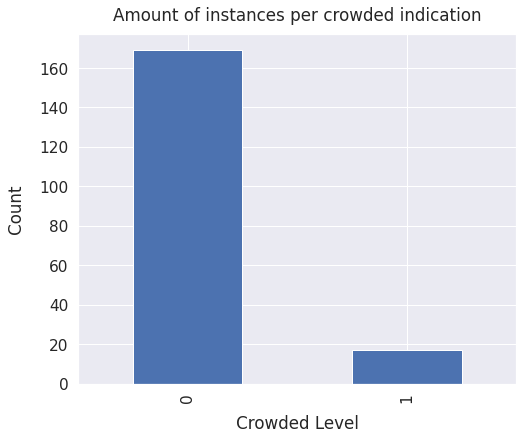

In [22]:
plot_df['Museumplein_crowded'].value_counts()
sns.set(font_scale=1.4)
plot_df['Museumplein_crowded'].value_counts().plot(kind='bar', figsize=(7,6))
plt.xlabel("Crowded Level", labelpad=12)
plt.ylabel("Count", labelpad=14)
plt.title("Amount of instances per crowded indication", y=1.02)

In [23]:
# all_locs_df.loc[(all_locs_df['DeDam'] > 900) & (all_locs_df['date'] > start_date_date)].count()

In [25]:
all_locs_df.loc[(all_locs_df['Museumplein_crowded'] == 1) & (all_locs_df['date'] > start_date_date)].count()

date                   17
Vondelpark             17
Museumplein            17
DeDam                  17
Vondelpark_crowded     17
Museumplein_crowded    17
DeDam_crowded          17
dtype: int64

# Making both Dataframes ready 
<a id="feature1"></a>
## Getting the correct data from the frames to get one location 
Museumplein is chosen first

### [Back To Table of Contents](#top_section)

In [26]:
# Choosing a specific location and creating a dataframe for that location for both tweets and for the crowdedness indication.
location = 'Museumplein'
tweet_df_local = tweet_df.loc[tweet_df['Location'] == location].reset_index(drop=True)
single_location_df = all_locs_df[['date', f'{location}', f'{location}_crowded']].reset_index(drop=True)
single_location_df.rename(columns={location:'Location', f'{location}_crowded': 'Crowded'}, inplace=True)
single_location_df.tail()


date  Location  Crowded
275  2021-07-08     353.0        0
276  2021-07-11     662.0        0
277  2021-07-12     444.0        0
278  2021-07-13     688.0        0
279  2021-07-14     689.0        0

# Feature 2: Hashtag & Most common words frequency


In [27]:
# Create a list of the dates that are used for this model, which will be the key for the vector.
date_df = tweet_df['date']
date_df.drop_duplicates(inplace=True)
dates = sorted(date_df.to_list())


In [28]:
# Create a list of most frequent words for a certain column
def create_values_range(mygroup, feature, top_n):
    
    daily_ht = [text for text in mygroup[f'{feature}']]
    daily_freq = nltk.FreqDist(sum(daily_ht, [])).most_common(top_n)
    values = [i[0] for i in daily_freq]
    
    return values

# In this function the data is gathered for 1 day, 3 days and 7 days before the actual date.
def create_all_features(date, my_df, feature, top_n):

    for i in range(1,8):
#         Create a variable that makes the previous day
        temp_date = date - datetime.timedelta(days=i)
    
#         One day before the date
        if i == 1:
            one_day = my_df.loc[my_df['date'] == temp_date]
            three_day = my_df.loc[my_df['date'] == temp_date]
            week = my_df.loc[my_df['date'] == temp_date]
#         3 days before the date
        if i < 3:
            three_day.append(my_df.loc[my_df['date'] == temp_date])
        
#         7 days before the date
        if i < 8:
            week.append(my_df.loc[my_df['date'] == temp_date])

#     Send the aquired tweets for the daterange to the function that returns a list of most common words for the send feature
    most_common_list1 = create_values_range(one_day, feature, top_n)
    most_common_list3 = create_values_range(three_day, feature, top_n)
    most_common_list7 = create_values_range(week, feature, top_n)
    temp_dict = {'day1':most_common_list1,'day3':most_common_list3,'day7':most_common_list7}
    
    return temp_dict

# Loop over the dates for each feature
def run_single_feature(feature, top_n):
    
    my_dict = {}

    for date in dates:
        my_dict[date] = create_all_features(date, tweet_df, feature, top_n)
    return my_dict


In [29]:
def create_string(mylist):
    return ' '.join(mylist)
    
def create_columns(feature):
    temp_corpus = tweet_df[f'{feature}'].apply(create_string).to_list()
    return temp_corpus


In [30]:
# Create the corpus plus BoW for each feature
def run_all_feature_functions(feature, top_n):
    tmp_corpus = create_columns(feature)
    my_dict = run_single_feature(feature, top_n)
    
    token_docs = [doc.split() for doc in tmp_corpus]
    all_tokens = set([word for sentence in token_docs for word in sentence])
    word_to_idx = {token:idx+1 for idx, token in enumerate(all_tokens)}
    day1 = []
    day3 = []
    day7 = []
    for key, value in my_dict.items():
    
        day1.append(create_string(value['day1']))
        day3.append(create_string(value['day3']))
        day7.append(create_string(value['day7']))
    
    bow = CountVectorizer().fit(tmp_corpus)
    
    bow_day1 = bow.fit_transform(day1)
    bow_day3 = bow.fit_transform(day3)
    bow_day7 = bow.fit_transform(day7)
    
    # converting to dataframe
    df1 = pd.DataFrame(bow_day1.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day1')
    df2 = pd.DataFrame(bow_day3.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day3')
    df3 = pd.DataFrame(bow_day7.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day7')
    

    tmp_f_df = df1.join(df2)
    tmp_f_df = tmp_f_df.join(df3)
    return tmp_f_df



In [31]:

def setup_invest(top_n, list_number):
    all_cols = []

    all_cols.append(['spacy_text', 'txt_bigram', 'txt_trigram'])
    all_cols.append(['lemma', 'lemma_bigram', 'lemma_trigram'])
    all_cols.append(['ent_date', 'ent_org', 'ent_event', 'ent_person', 'ent_time', 'ent_loc'])
    all_cols.append(['hashtags', 'mentions'])
    all_cols.append(['spacy_text', 'txt_bigram', 'txt_trigram', 'lemma', 'lemma_bigram', 'lemma_trigram', 'ent_date', 'ent_org', 'ent_event', 'ent_person', 'ent_time', 'ent_loc', 'hashtags', 'mentions'])

    ready_df = pd.DataFrame(dates)

    for x in all_cols[list_number]:
        ready_df = ready_df.join(run_all_feature_functions(x, top_n), rsuffix=x)

    ready_df.rename(columns={0:'date'}, inplace=True)

    combine_df = ready_df.merge(single_location_df,how='outer', on='date')
    combine_df = combine_df.dropna()
    combine_df = combine_df.reset_index(drop=True)

#     combine_df['full_day'] = combine_df['date'].apply(lambda x: x.weekday())

    return combine_df
    

# Regression
<a id="regressions"></a>
Add some text for the regression choices
### [Back To Table of Contents](#top_section)

In [32]:
def plot_confusion_matrix(folder1, folder2,count,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Plots_small/Normal/{folder1}/{folder2}/conf_matrix_{count}.png', bbox_inches='tight')



In [33]:
list_names = ['text', 'lemmas', 'entities', 'other', 'all']
dict_with_frames = {}
for lst_number in range(5):
    
    tmp_dict = {}
    print(f'Working on Top 10 and list {list_names[lst_number]}')
    top_n = 10
    tmp_dict[top_n] = setup_invest(top_n, lst_number).drop(columns=['date', 'Location'])
    
    print(f'Working on Top 30 and list {list_names[lst_number]}')
    top_n = 30
    tmp_dict[top_n] = setup_invest(top_n, lst_number).drop(columns=['date', 'Location'])

    print(f'Working on Top 50 and list {list_names[lst_number]}')
    top_n = 50
    tmp_dict[top_n] = setup_invest(top_n, lst_number).drop(columns=['date', 'Location'])
    
    print(f'Working on Top 100 and list {list_names[lst_number]}')
    top_n = 100
    tmp_dict[top_n] = setup_invest(top_n, lst_number).drop(columns=['date', 'Location'])
    
    dict_with_frames[lst_number] = tmp_dict


Working on Top 10 and list text
Working on Top 30 and list text
Working on Top 50 and list text
Working on Top 100 and list text
Working on Top 10 and list lemmas
Working on Top 30 and list lemmas
Working on Top 50 and list lemmas
Working on Top 100 and list lemmas
Working on Top 10 and list entities
Working on Top 30 and list entities
Working on Top 50 and list entities
Working on Top 100 and list entities
Working on Top 10 and list other
Working on Top 30 and list other
Working on Top 50 and list other
Working on Top 100 and list other
Working on Top 10 and list all
Working on Top 30 and list all
Working on Top 50 and list all
Working on Top 100 and list all


# Newest run


In [34]:
# First model
def create_accuracies(accur_df, f1, f2):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=22)


    X = accur_df.drop(columns='Crowded').values
    y=accur_df.Crowded.values

    count = 0
    total = []
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegressionCV(n_jobs=-1)
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        count +=1
#         print(f'Accuracy for split {count}: {acc}')
        total.append(acc)
        cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

        plt.figure()

        plot_confusion_matrix(f1, f2,count,cnf_matrix, classes=['Normal','Crowded'],
                          title=f'Confusion matrix split {count}')
    print(f'Mean: {np.mean(total)}' )
    print(f'Standard Deviation: {np.std(total)}\n' )

Accuracy for text and 10:
Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for text and 30:
Mean: 0.832258064516129
Standard Deviation: 0.012903225806451644

Accuracy for text and 50:
Mean: 0.8064516129032258
Standard Deviation: 0.028852490032255377

Accuracy for text and 100:
Mean: 0.8129032258064516
Standard Deviation: 0.024139725075960936

Accuracy for lemmas and 10:
Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for lemmas and 30:
Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for lemmas and 50:
Mean: 0.8193548387096774
Standard Deviation: 0.015803159630859254

Accuracy for lemmas and 100:
Mean: 0.832258064516129
Standard Deviation: 0.03761904448287292

Accuracy for entities and 10:
Mean: 0.8387096774193548
Standard Deviation: 0.03533693919388169

Accuracy for entities and 30:
Mean: 0.8774193548387096
Standard Deviation: 0.02413972507596089

Accuracy for entities and 50:
Mean: 0.8774193548387

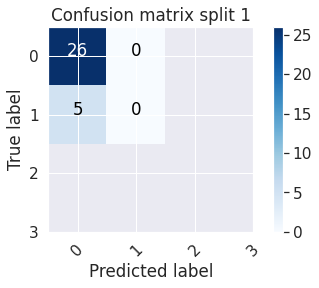

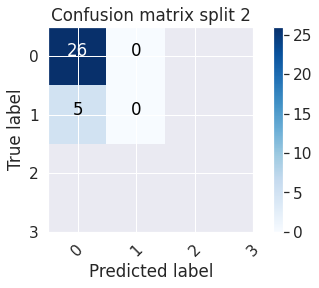

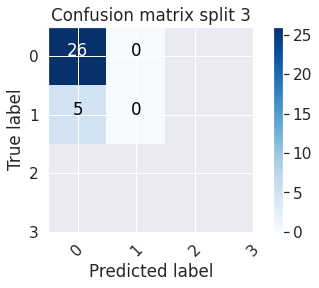

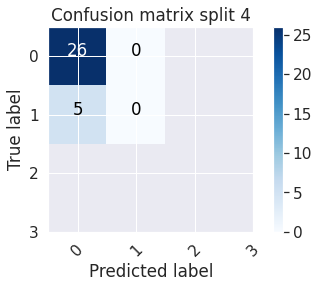

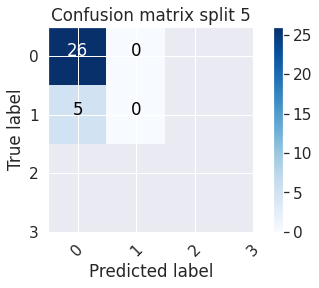

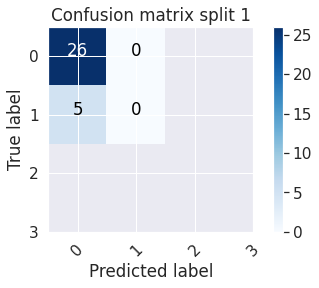

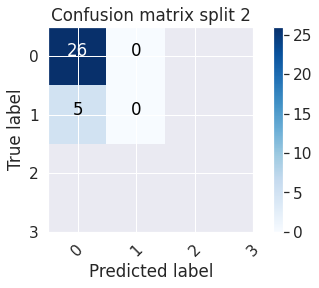

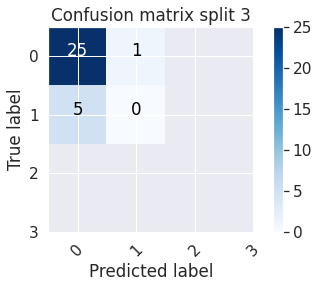

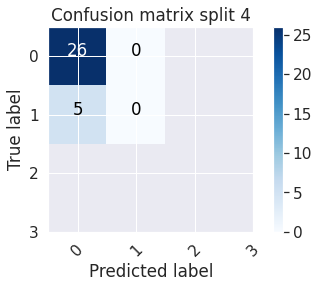

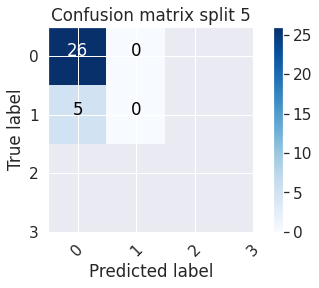

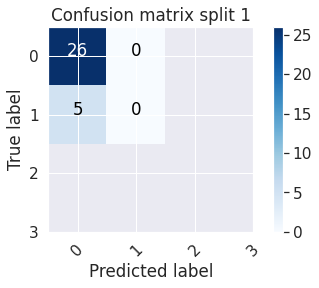

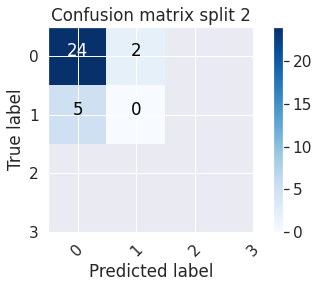

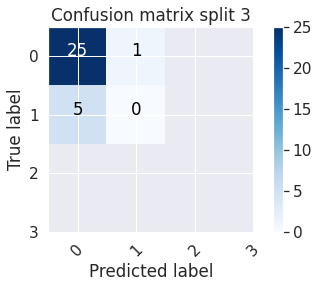

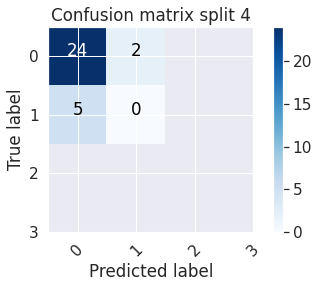

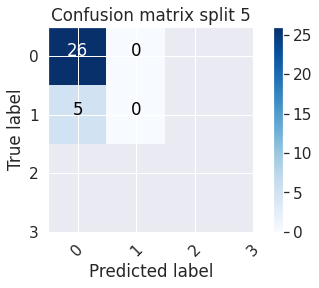

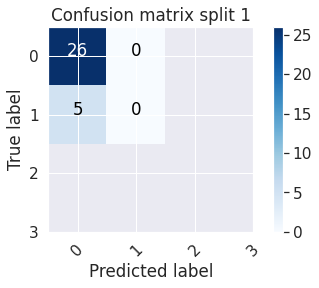

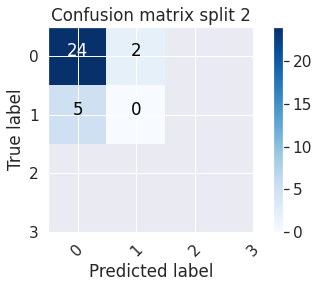

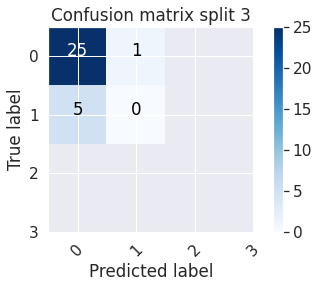

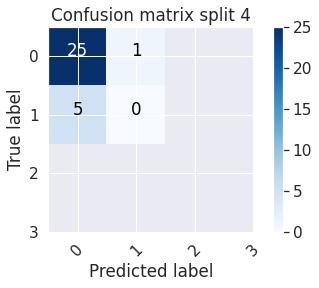

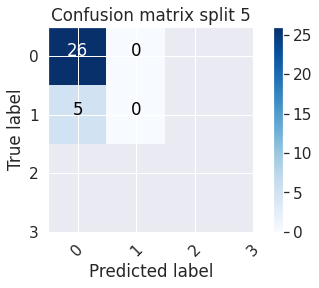

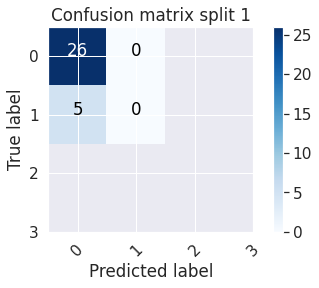

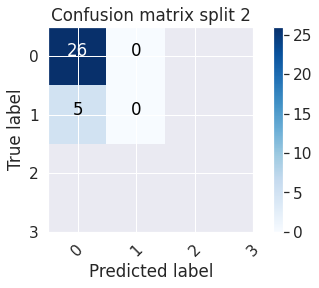

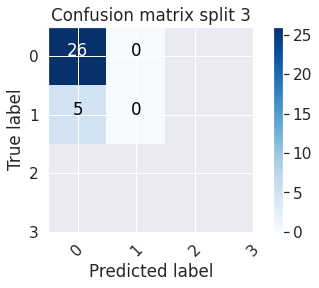

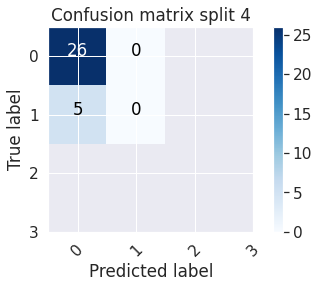

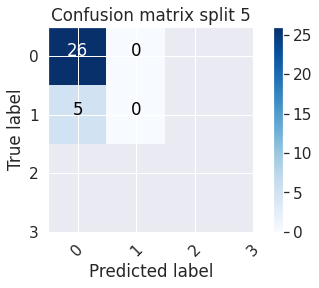

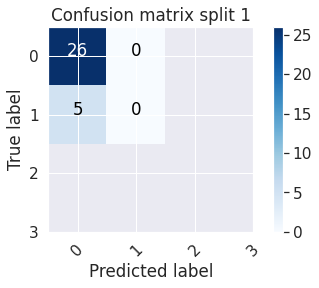

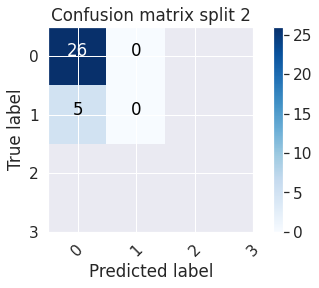

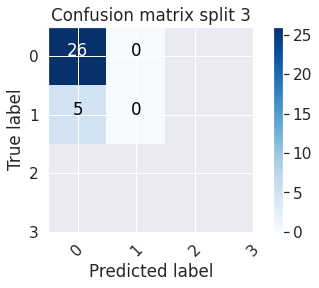

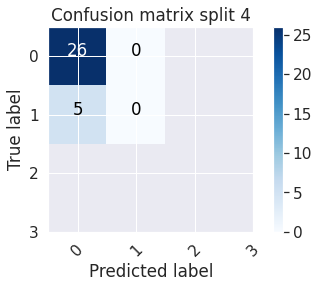

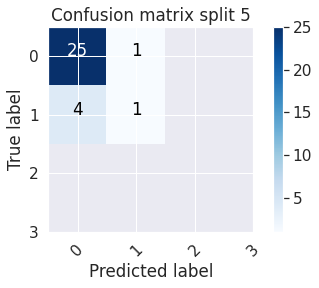

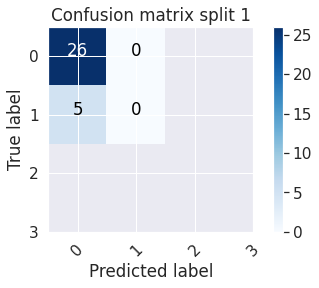

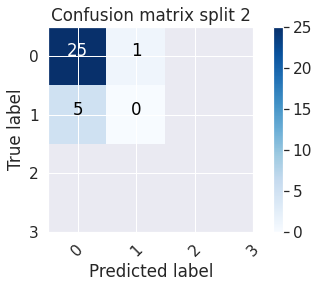

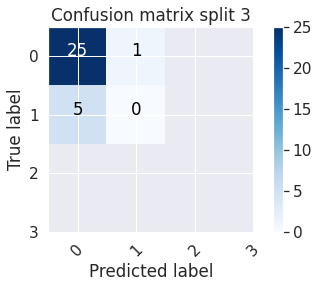

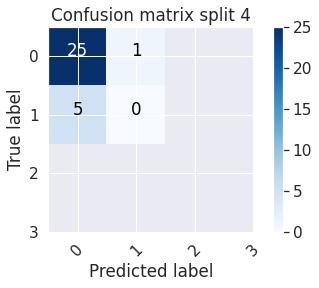

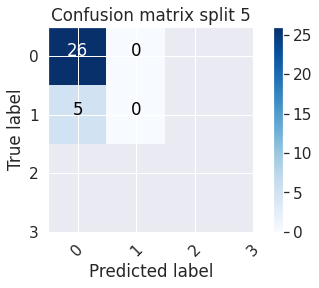

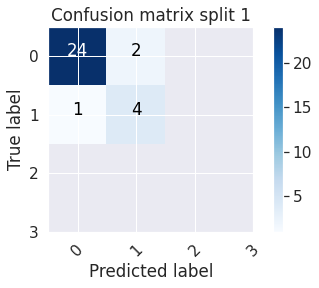

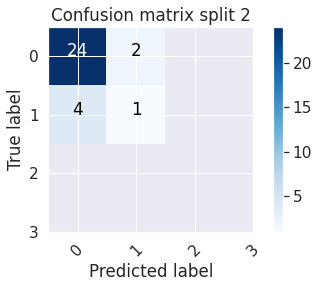

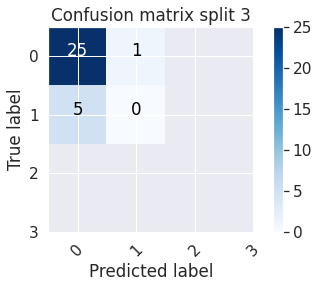

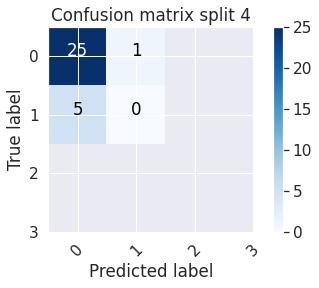

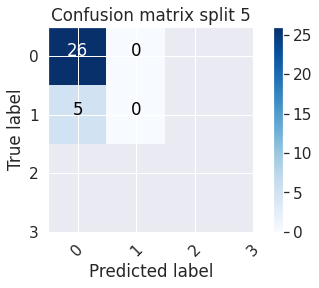

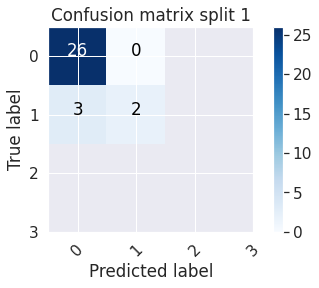

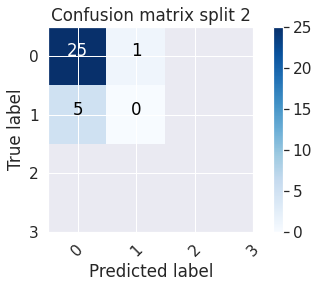

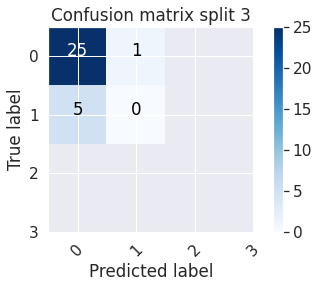

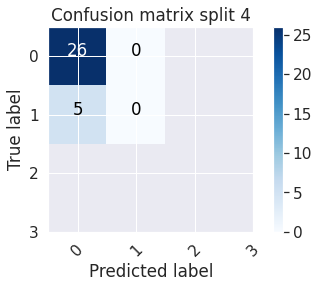

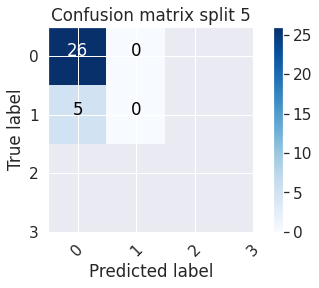

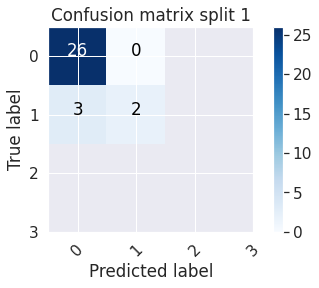

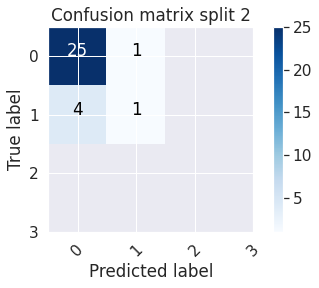

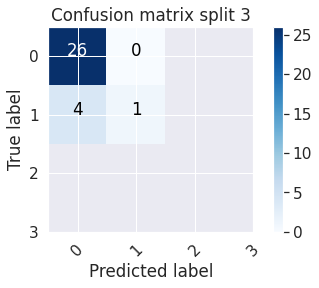

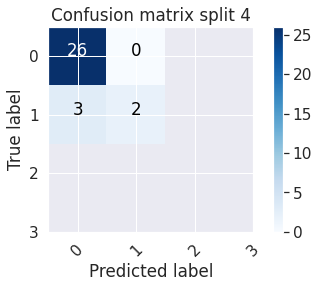

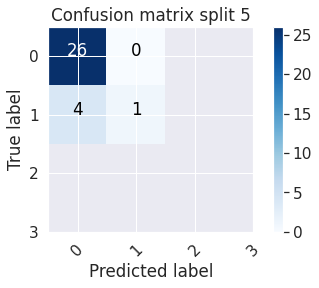

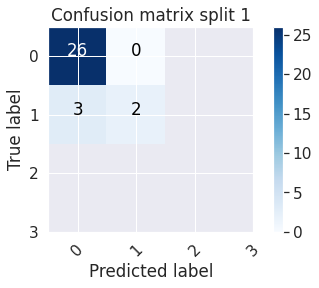

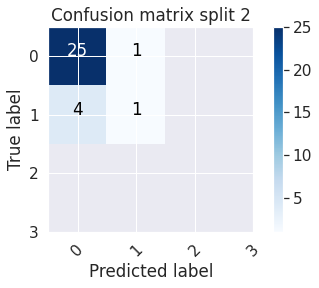

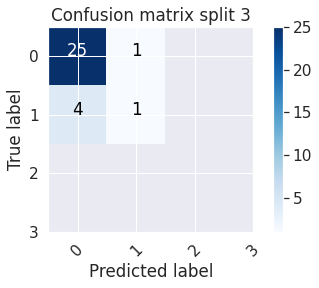

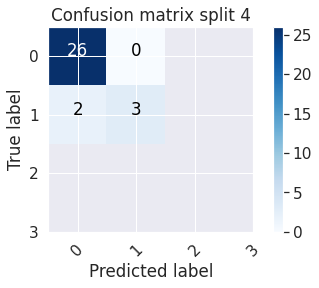

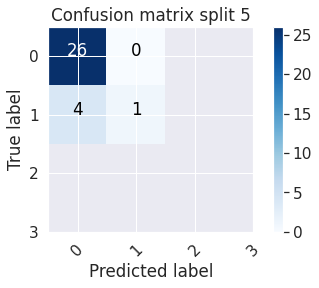

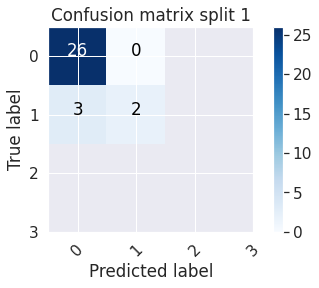

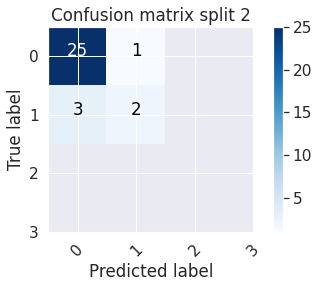

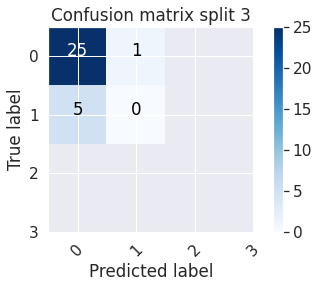

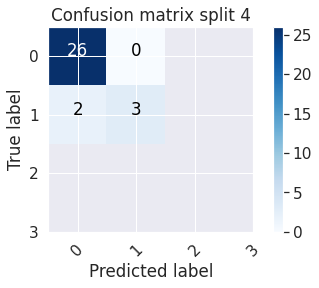

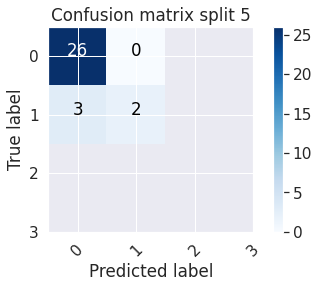

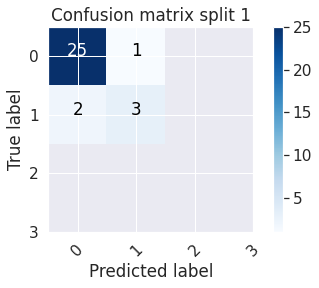

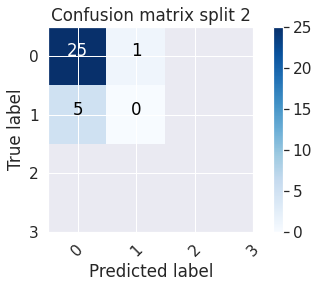

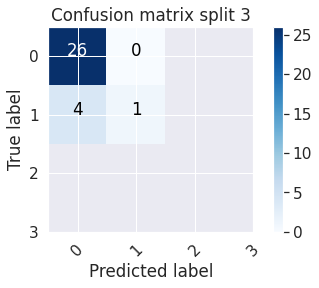

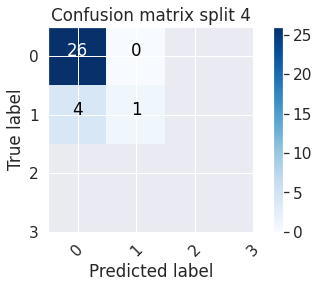

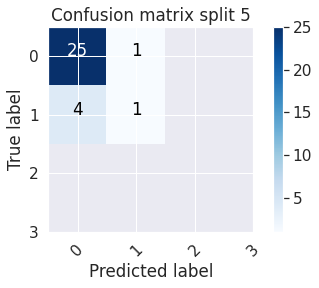

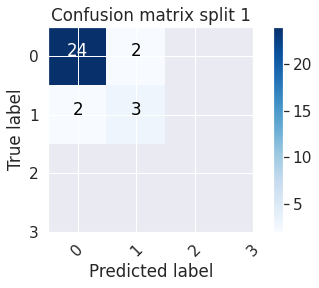

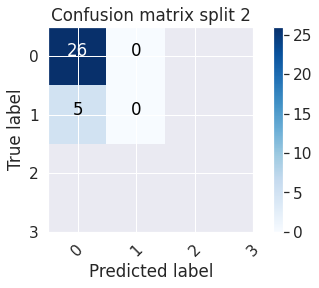

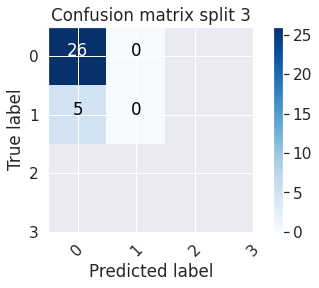

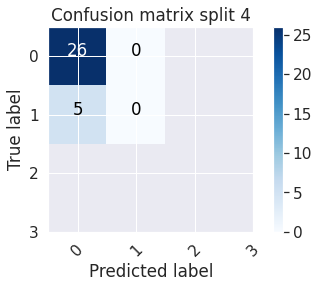

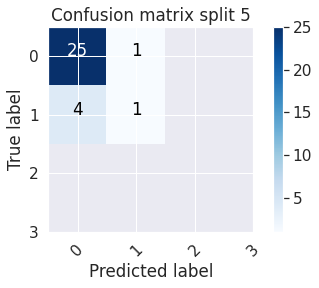

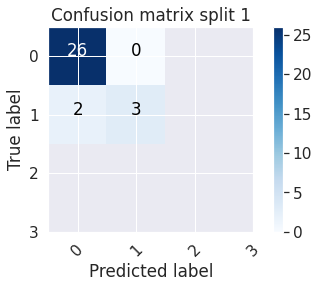

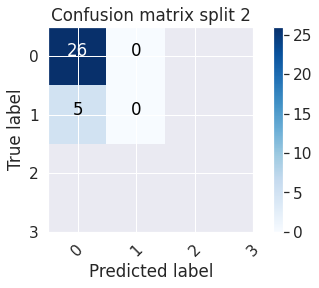

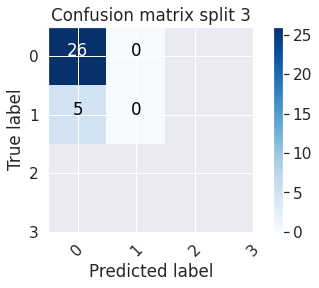

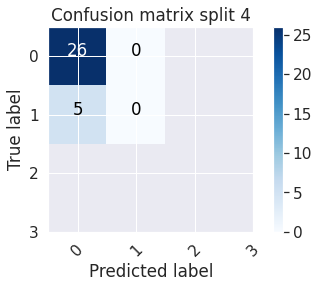

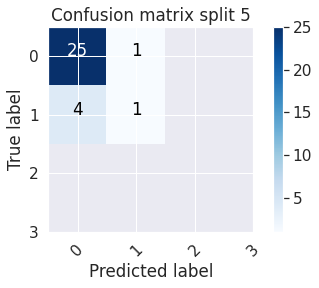

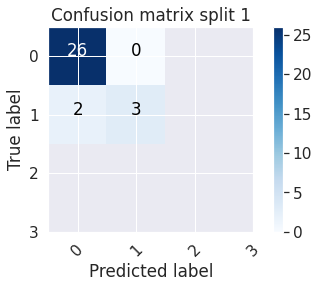

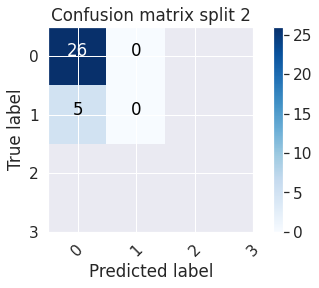

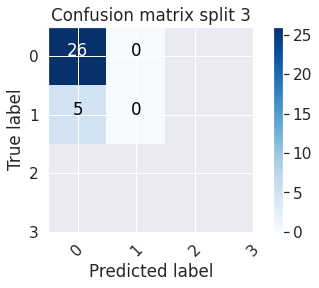

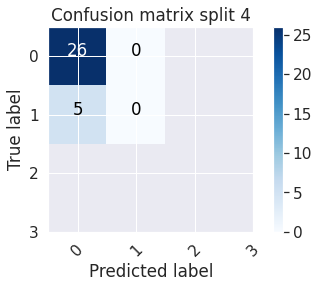

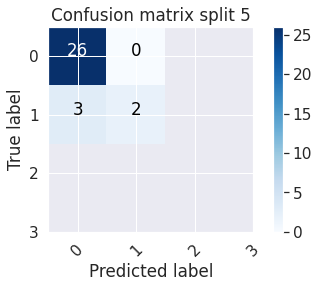

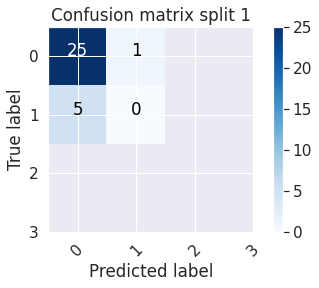

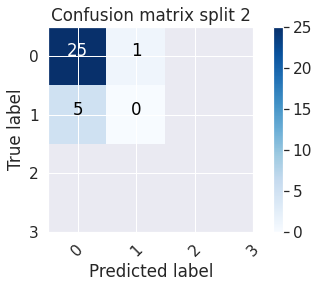

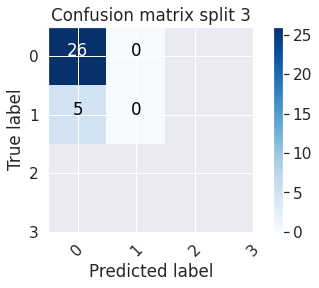

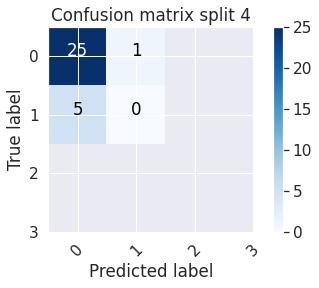

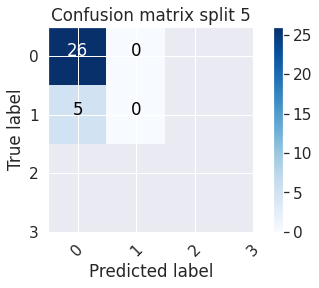

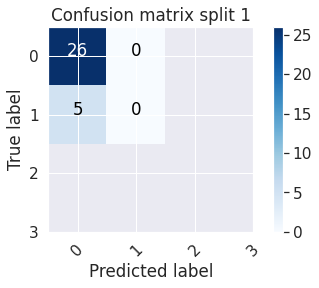

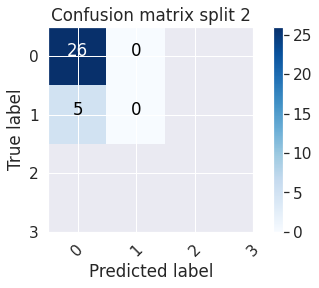

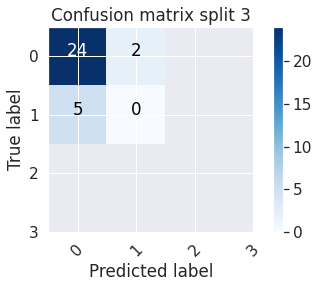

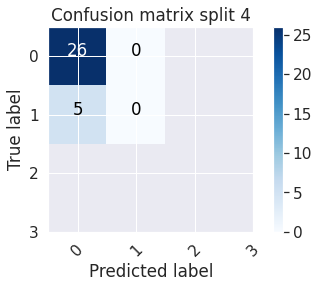

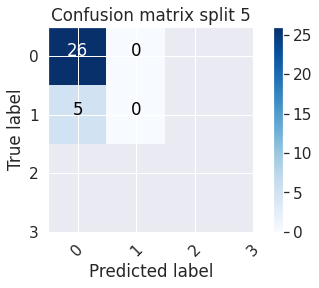

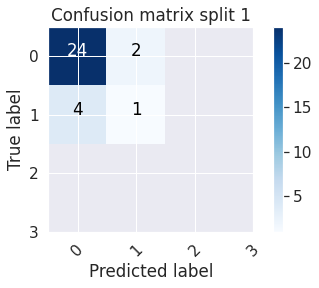

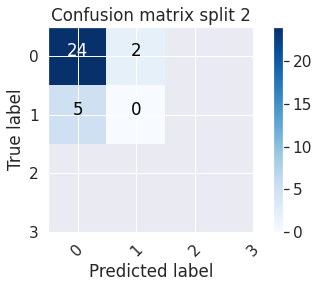

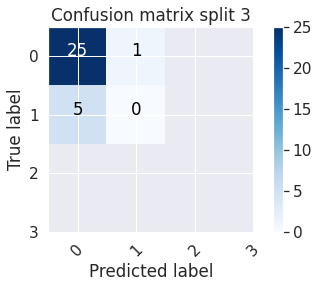

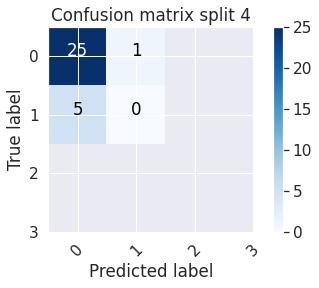

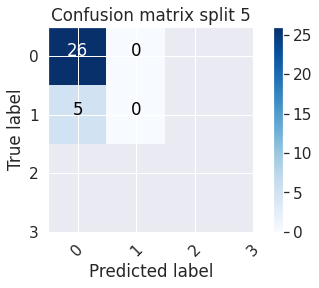

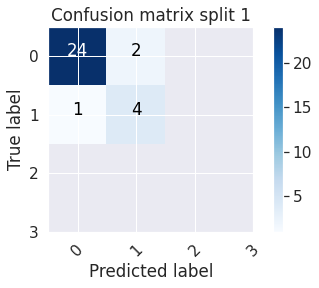

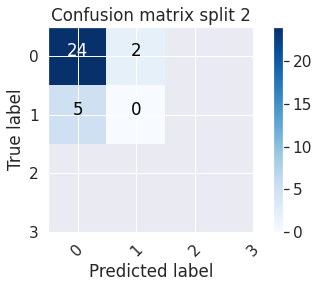

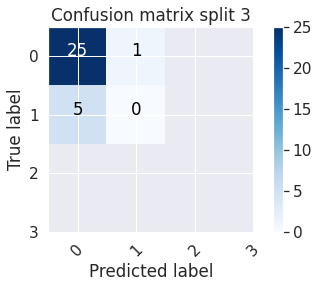

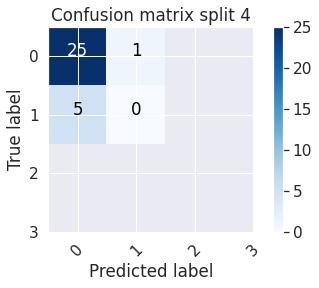

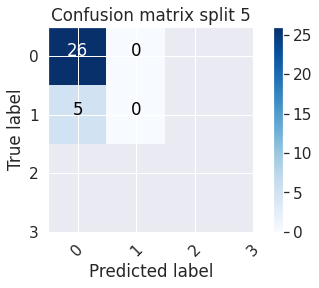

In [36]:
working_dict1 = dict_with_frames

for list_type, curr_dict in working_dict1.items():
    current_list = list_names[list_type]
    for k, v in curr_dict.items():
#         if k == 10 or k == 30 or k == 50:
        print(f'Accuracy for {current_list} and {k}:')
        create_accuracies(v, str(current_list), str(k))

# Run 1

In [40]:
# First model
def create_accuracies(accur_df, f1, f2):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=22)


    X = accur_df.drop(columns='Crowded').values
    y=accur_df.Crowded.values

    count = 0
    total = []
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegressionCV(n_jobs=-1, class_weight='balanced')
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        count +=1
#         print(f'Accuracy for split {count}: {acc}')
        total.append(acc)
        cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

        plt.figure()

        plot_confusion_matrix(f1, f2,count,cnf_matrix, classes=['Normal','Crowded'],
                          title=f'Confusion matrix split {count}')
    print(f'Mean: {np.mean(total)}' )
    print(f'Standard Deviation: {np.std(total)}\n' )

Accuracy for text and 10:
Mean: 0.8193548387096774
Standard Deviation: 0.04375696763306625

Accuracy for text and 30:
Mean: 0.7870967741935484
Standard Deviation: 0.0598297967451336

Accuracy for text and 50:
Mean: 0.7806451612903226
Standard Deviation: 0.037619044482872906

Accuracy for text and 100:
Mean: 0.8193548387096774
Standard Deviation: 0.04827945015192183

Accuracy for lemmas and 10:
Mean: 0.7806451612903226
Standard Deviation: 0.012903225806451599

Accuracy for lemmas and 30:
Mean: 0.7870967741935484
Standard Deviation: 0.03289690008769539

Accuracy for lemmas and 50:
Mean: 0.8193548387096774
Standard Deviation: 0.0328969000876954

Accuracy for lemmas and 100:
Mean: 0.8451612903225806
Standard Deviation: 0.047409478892577656

Accuracy for entities and 10:
Mean: 0.8903225806451612
Standard Deviation: 0.0258064516129032

Accuracy for entities and 30:
Mean: 0.8903225806451612
Standard Deviation: 0.0158031596308592

Accuracy for entities and 50:
Mean: 0.896774193548387
Standard 

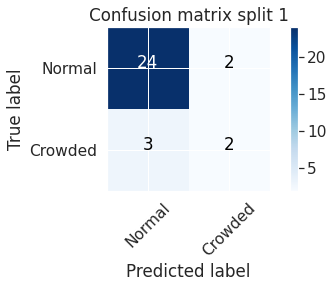

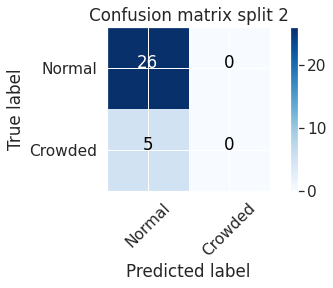

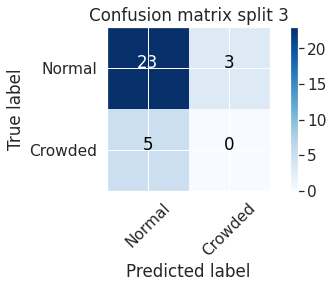

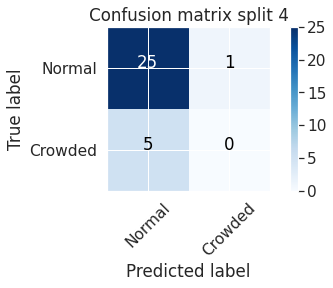

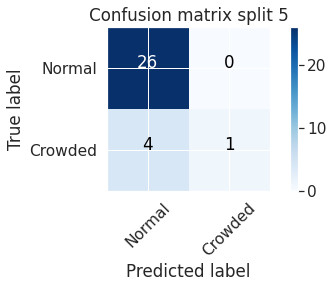

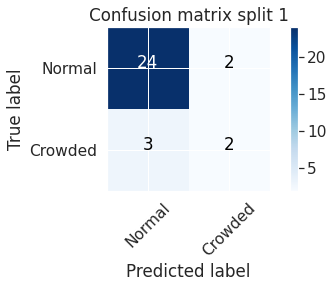

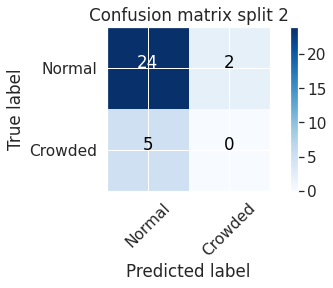

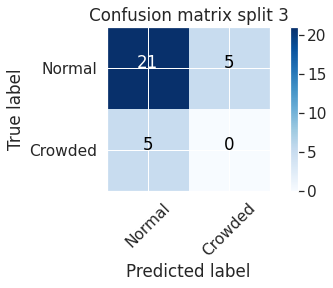

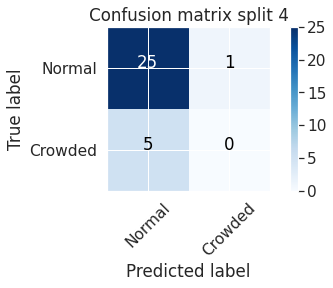

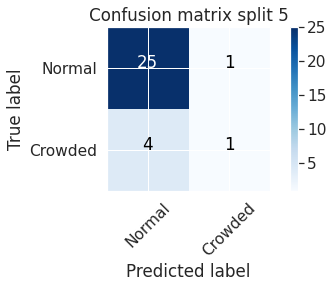

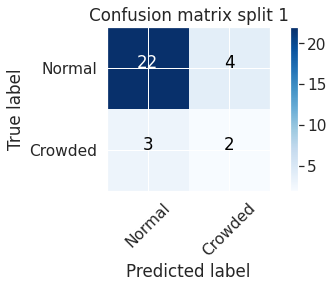

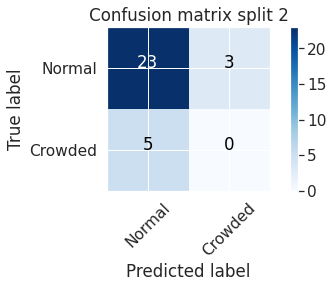

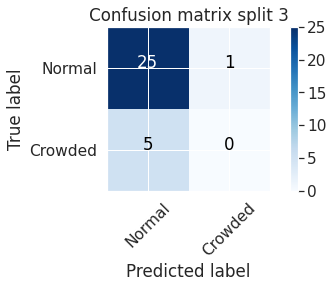

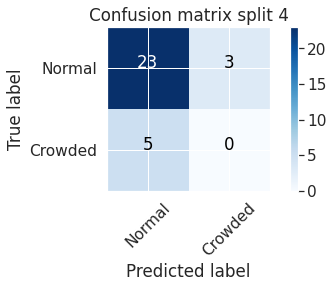

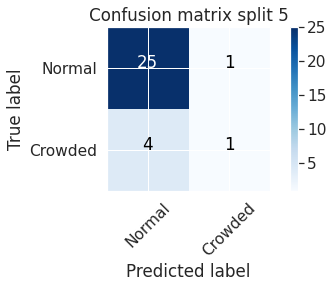

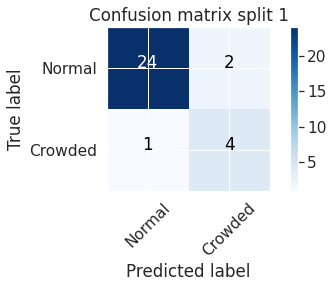

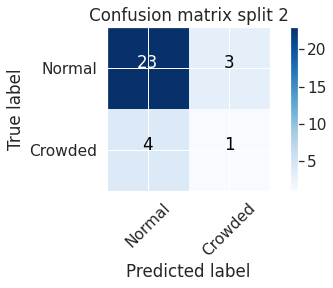

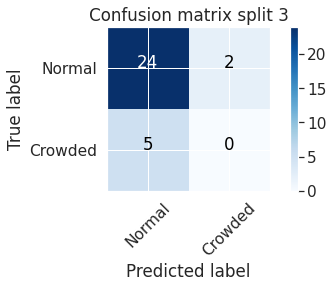

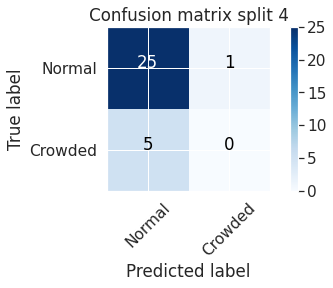

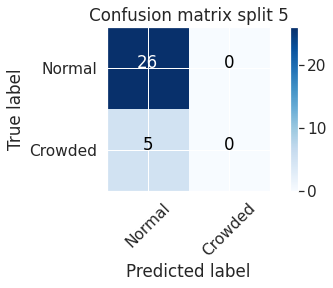

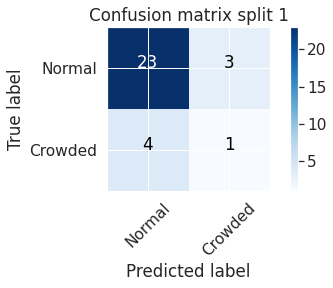

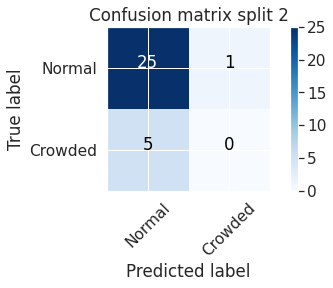

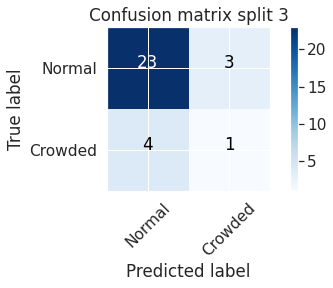

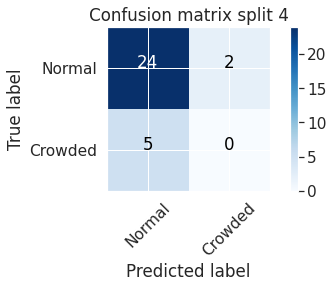

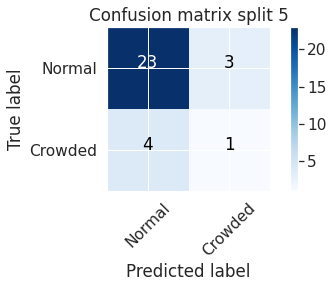

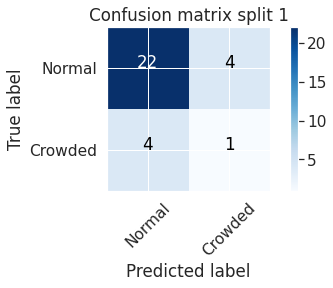

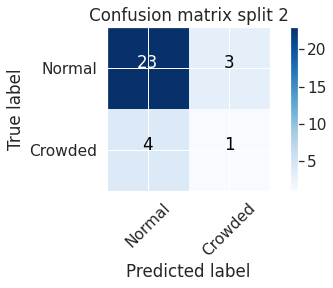

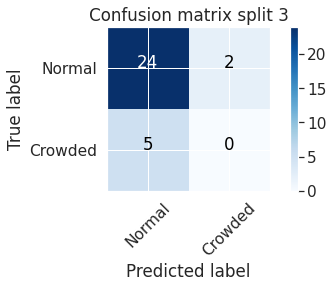

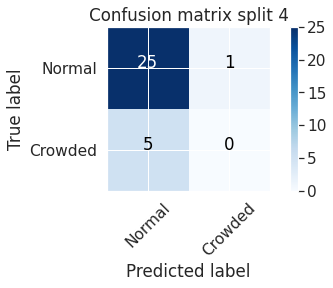

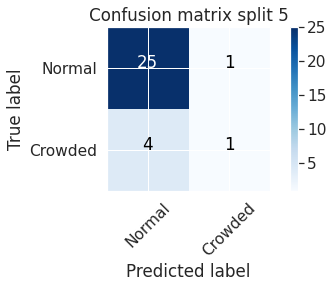

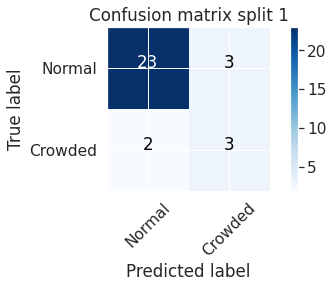

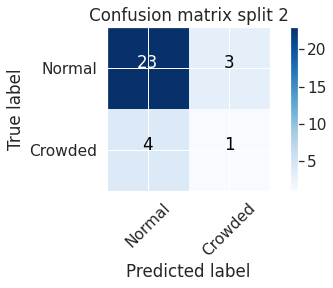

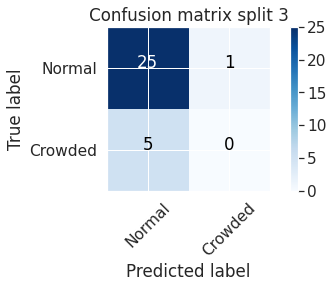

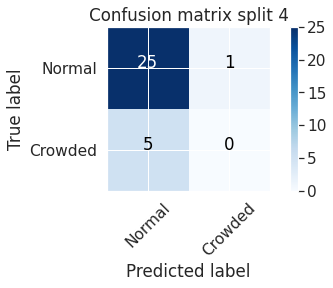

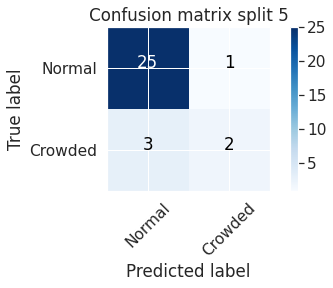

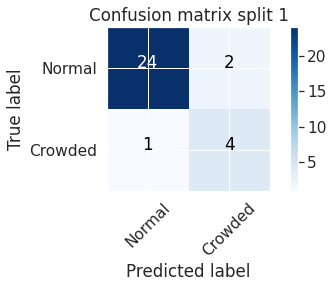

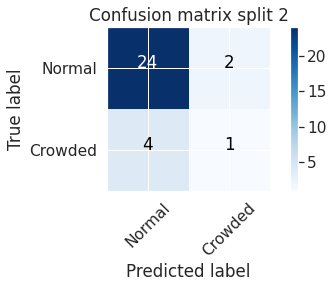

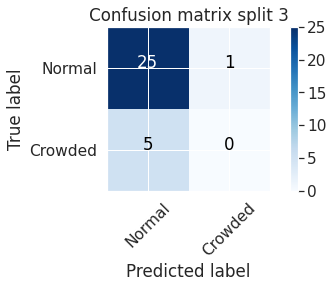

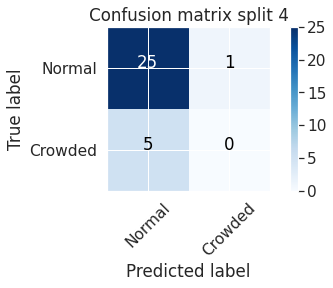

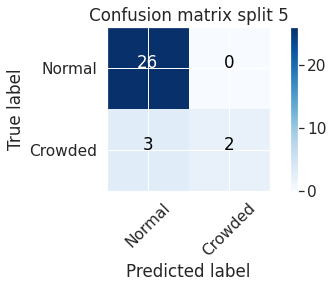

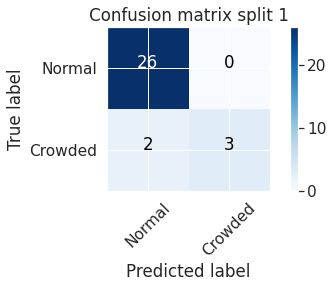

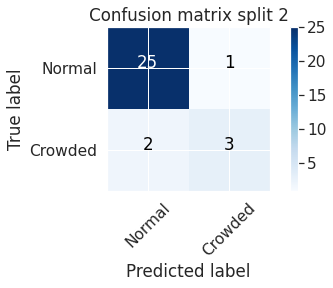

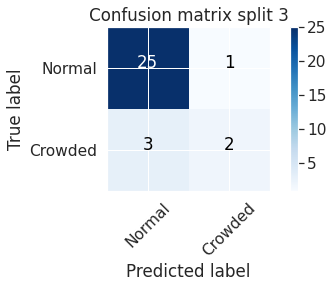

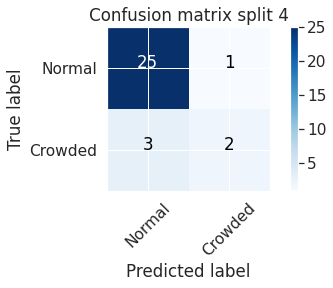

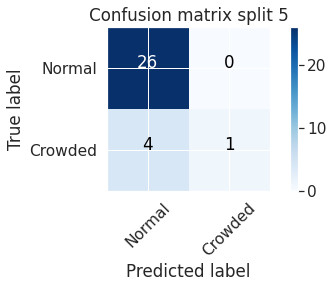

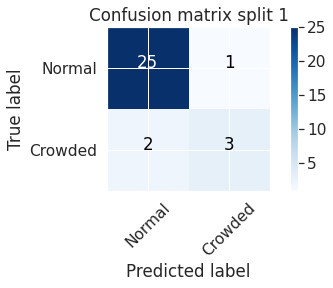

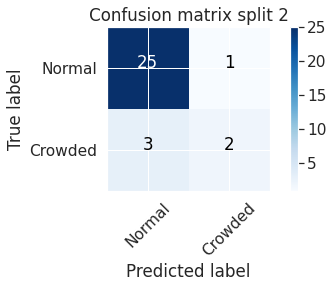

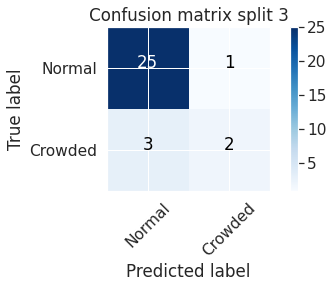

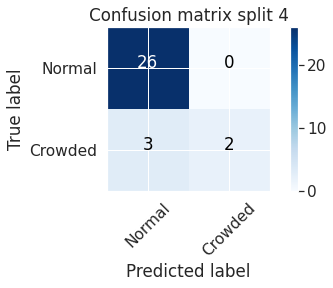

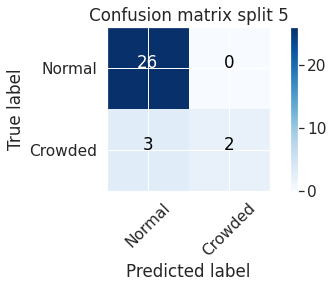

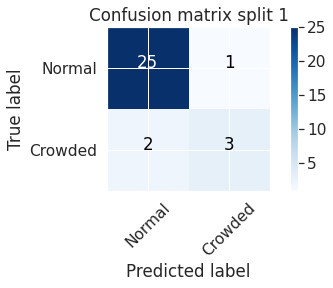

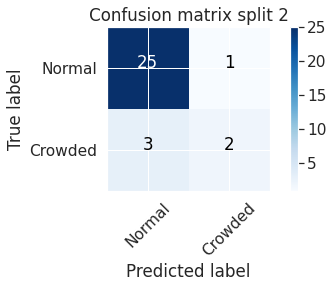

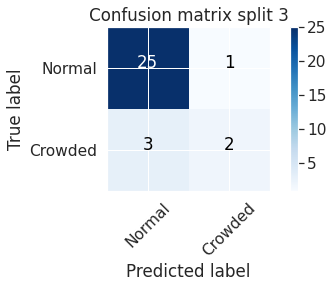

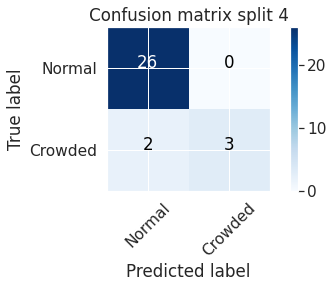

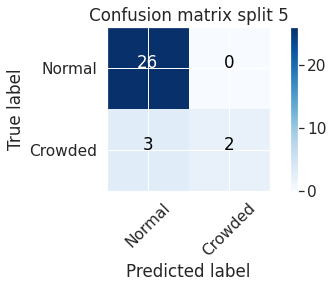

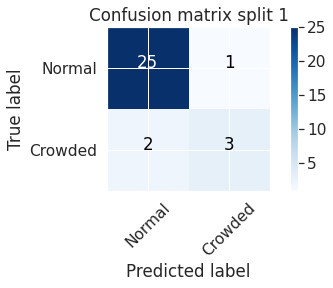

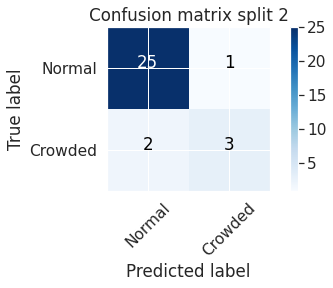

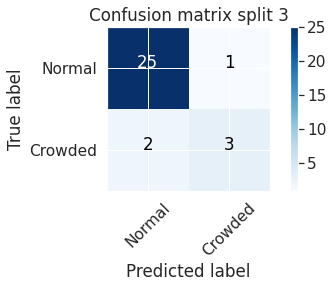

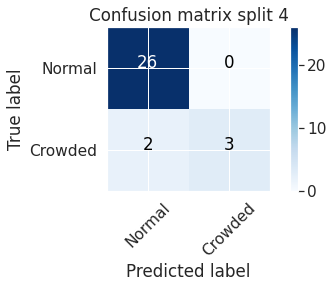

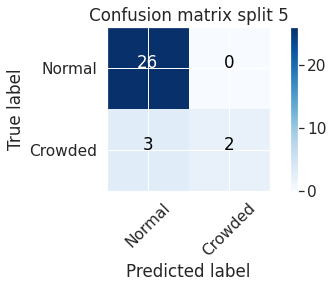

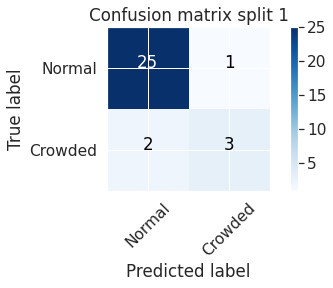

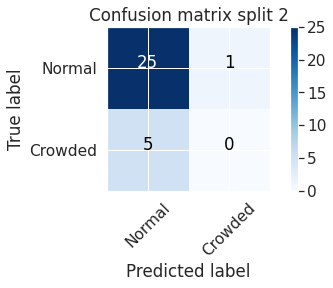

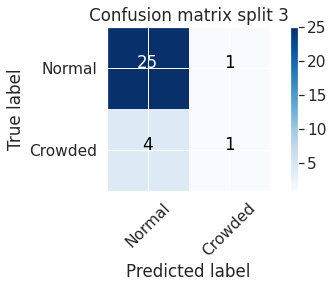

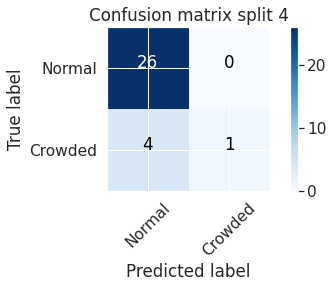

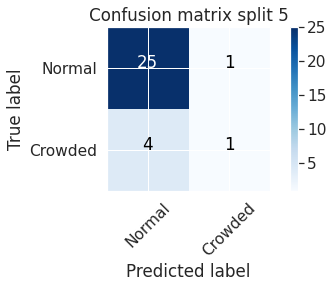

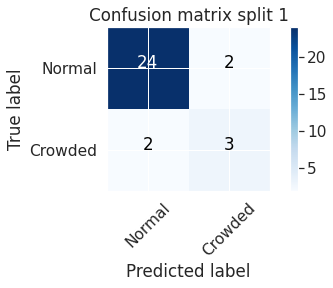

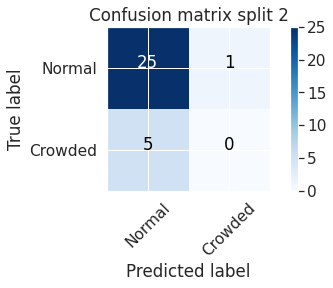

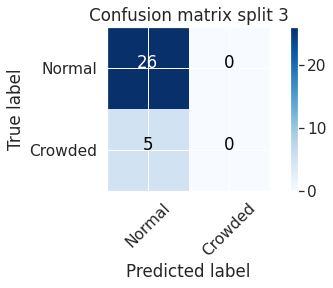

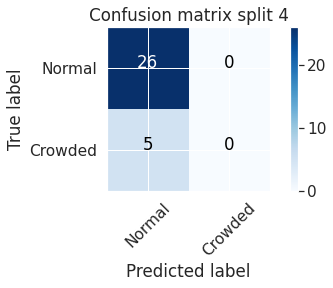

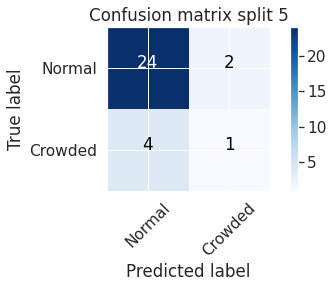

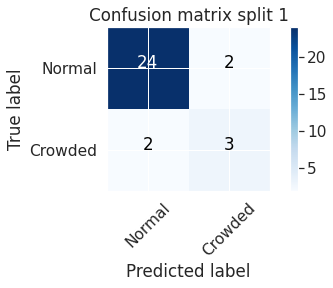

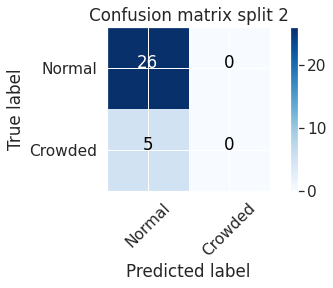

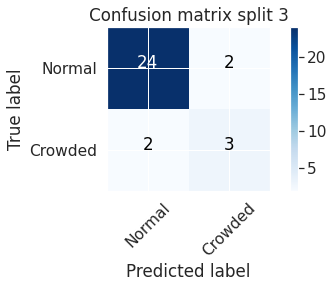

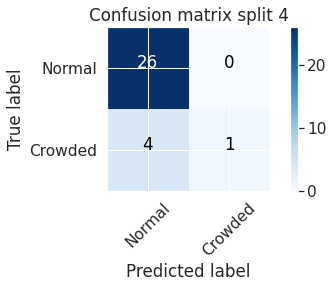

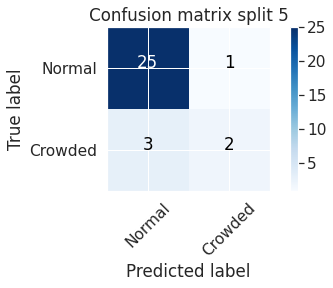

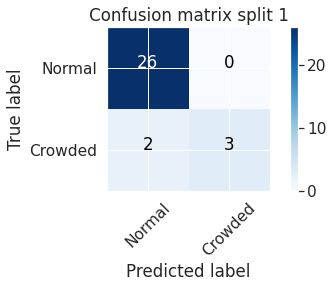

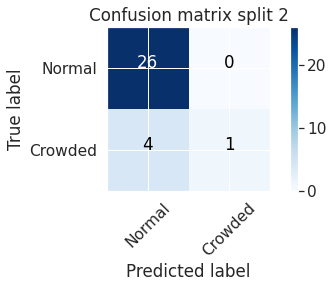

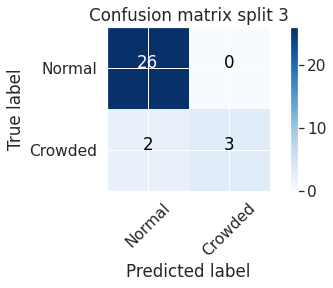

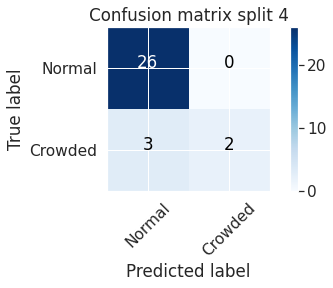

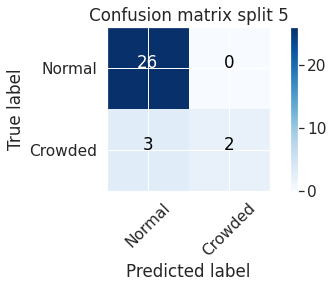

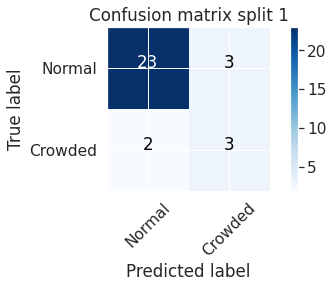

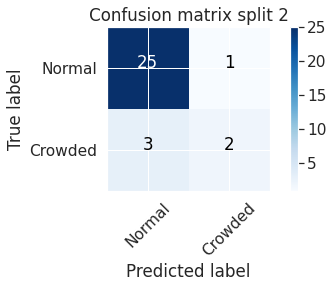

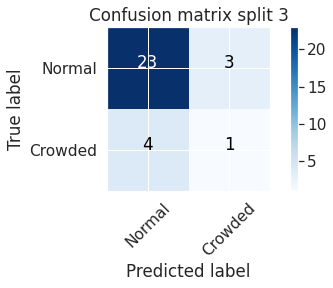

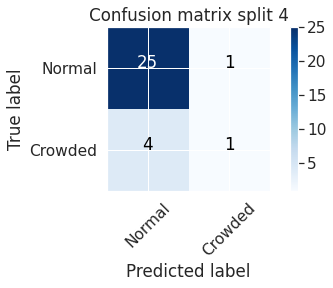

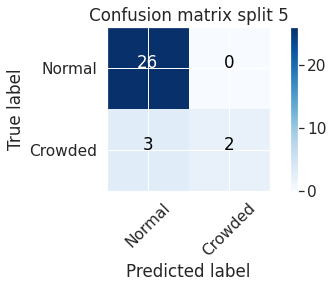

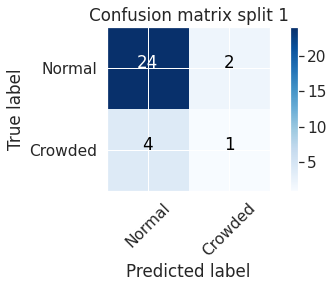

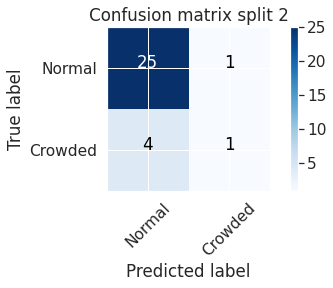

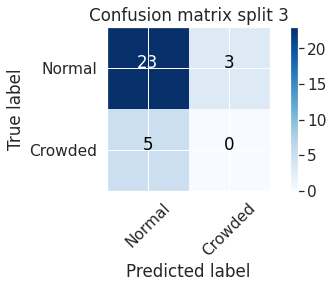

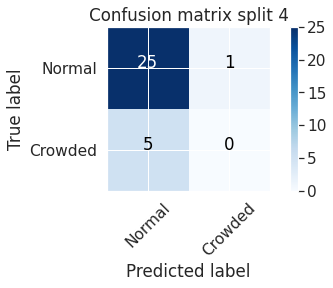

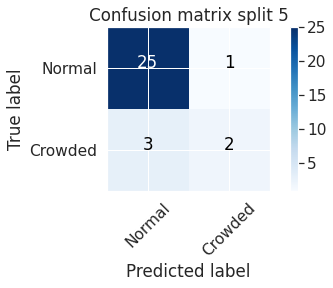

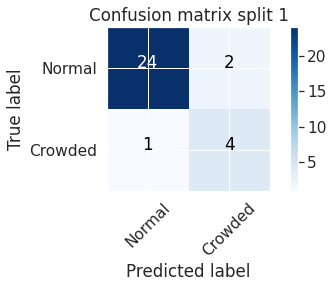

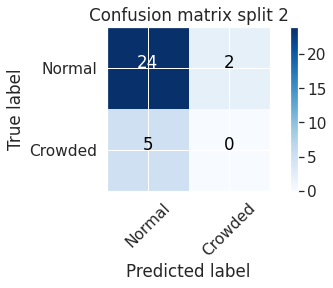

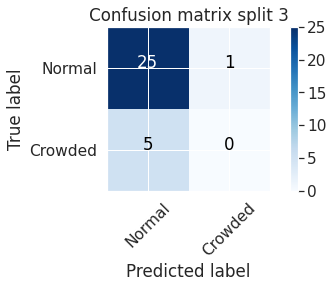

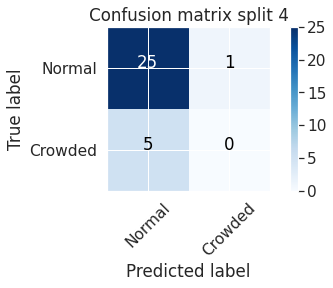

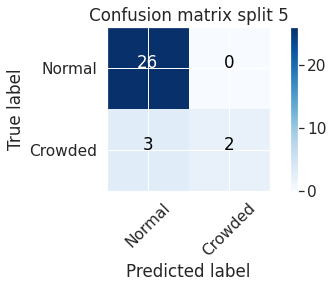

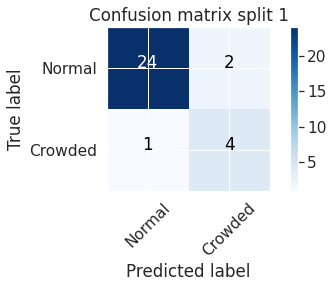

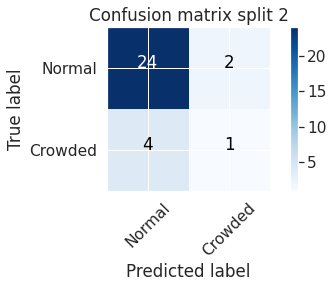

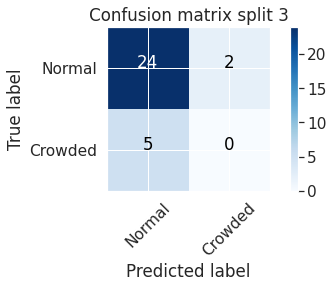

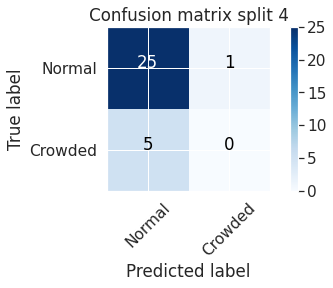

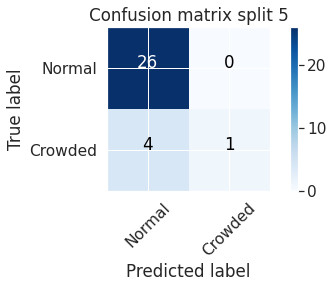

In [41]:
working_dict1 = dict_with_frames

for list_type, curr_dict in working_dict1.items():
    current_list = list_names[list_type]
    for k, v in curr_dict.items():
        print(f'Accuracy for {current_list} and {k}:')
        create_accuracies(v, str(current_list), str(k))


# Run 2

In [42]:
def plot_confusion_matrix(folder1, folder2,count,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Plots_small/balanced2/{folder1}/{folder2}/conf_matrix_{count}.png', bbox_inches='tight')



In [43]:
# First model
def create_accuracies(accur_df, f1, f2):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=22)


    X = accur_df.drop(columns='Crowded').values
    y=accur_df.Crowded.values

    count = 0
    total = []
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegressionCV(n_jobs=-1, solver='saga')
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        count +=1

        total.append(acc)
        cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

        plt.figure()

        plot_confusion_matrix(f1, f2,count,cnf_matrix, classes=['Normal','Crowded'],
                          title=f'Confusion matrix split {count}')
    print(f'Mean: {np.mean(total)}' )
    print(f'Standard Deviation: {np.std(total)}\n' )

Accuracy for text and 10:

Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for text and 30:

Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for text and 50:

Mean: 0.832258064516129
Standard Deviation: 0.012903225806451644

Accuracy for text and 100:

Mean: 0.8129032258064516
Standard Deviation: 0.024139725075960936

Accuracy for lemmas and 10:

Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for lemmas and 30:

Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for lemmas and 50:

Mean: 0.8387096774193548
Standard Deviation: 1.1102230246251565e-16

Accuracy for lemmas and 100:

Mean: 0.8193548387096774
Standard Deviation: 0.015803159630859254

Accuracy for entities and 10:

Mean: 0.8258064516129032
Standard Deviation: 0.015803159630859254

Accuracy for entities and 30:

Mean: 0.8580645161290322
Standard Deviation: 0.03289690008769539

Accuracy for entities and 50:

Mea

KeyboardInterrupt: 

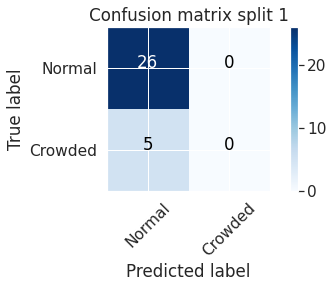

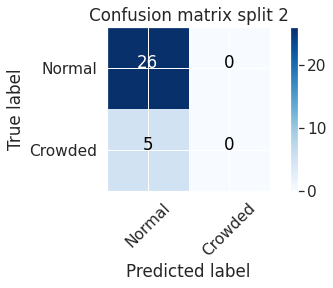

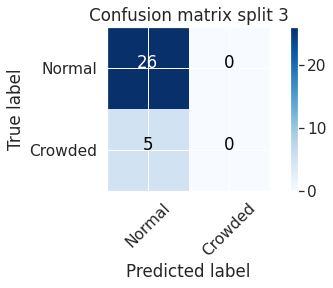

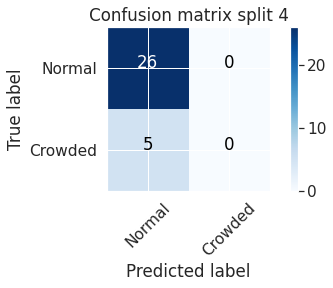

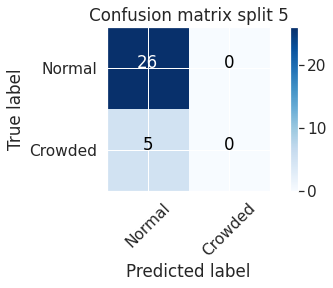

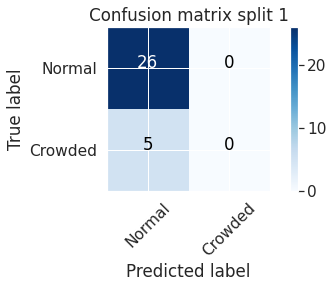

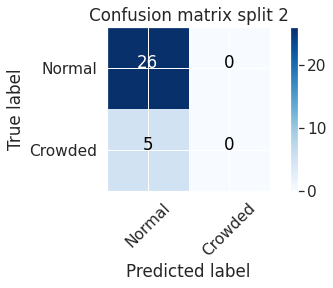

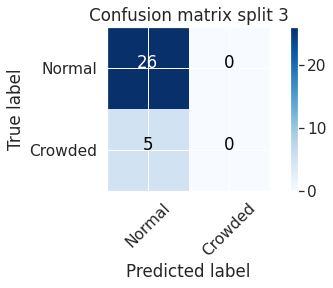

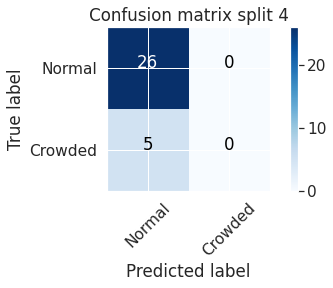

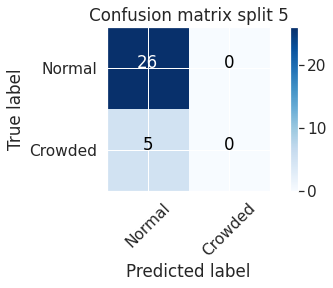

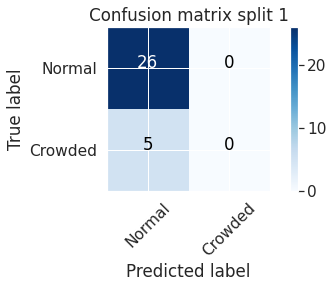

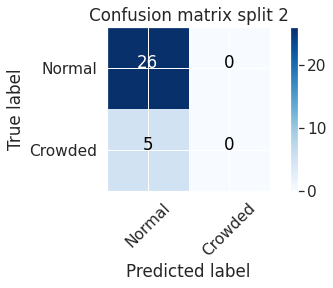

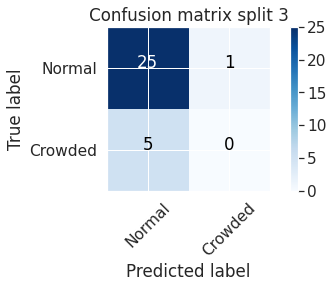

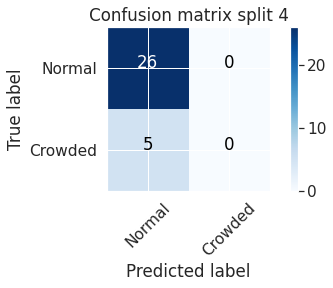

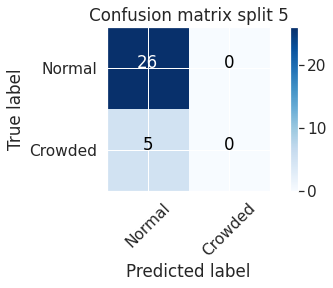

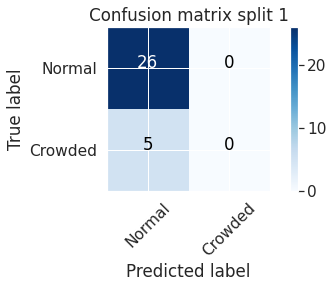

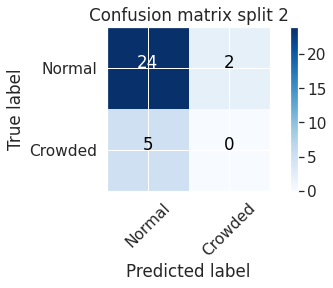

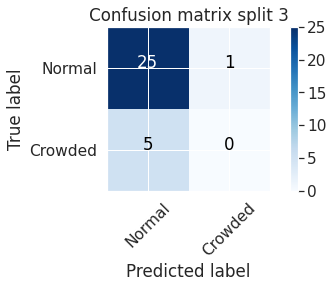

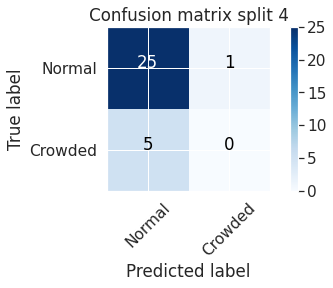

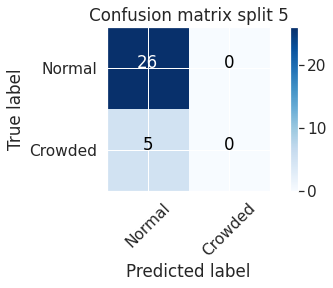

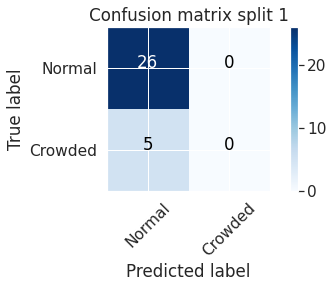

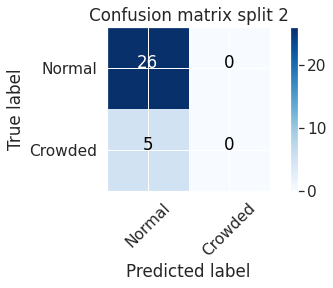

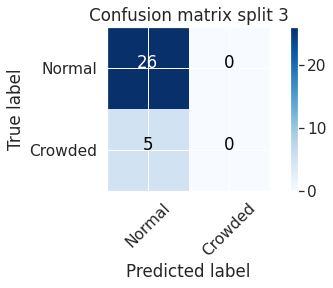

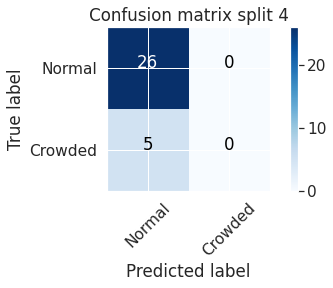

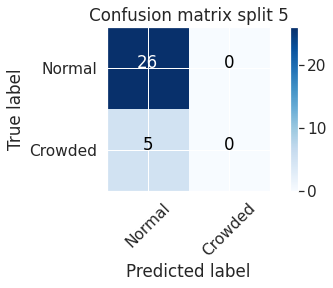

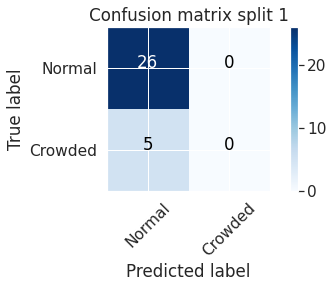

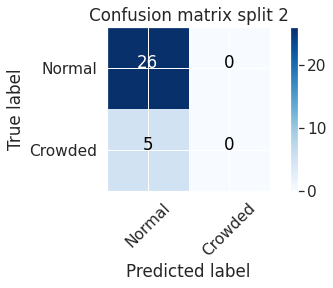

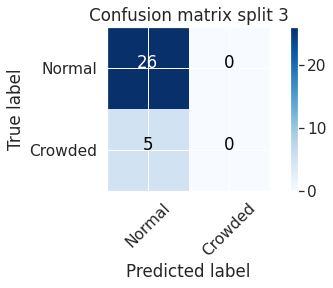

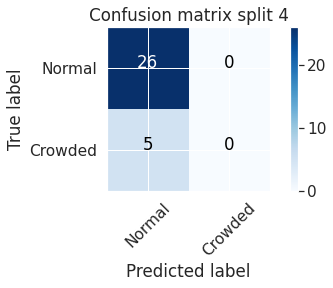

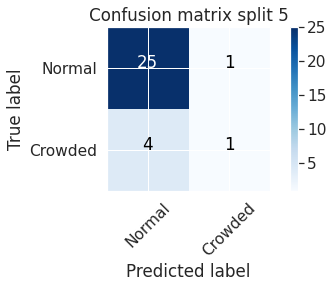

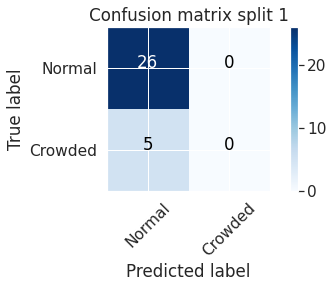

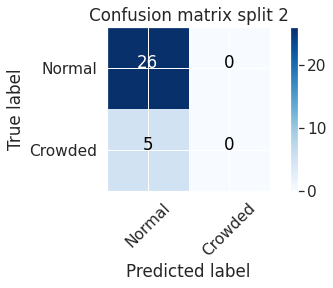

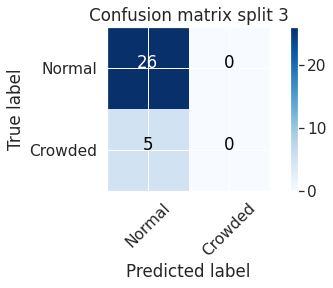

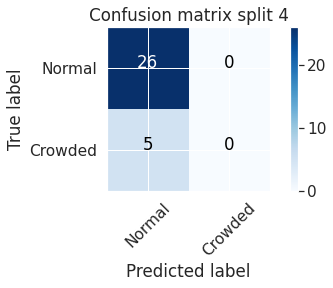

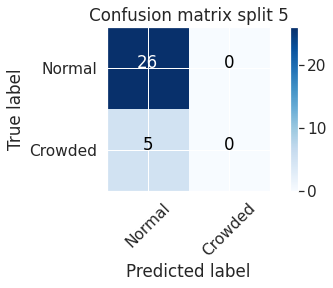

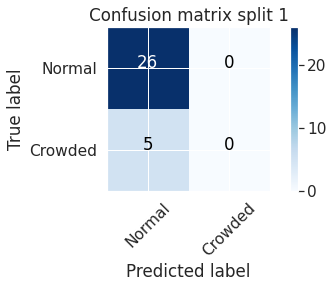

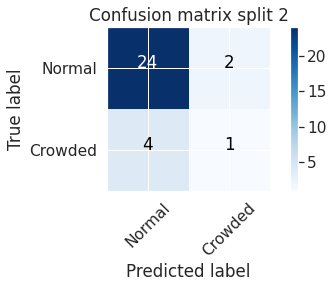

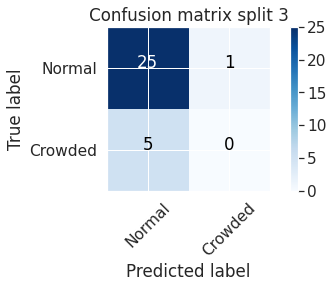

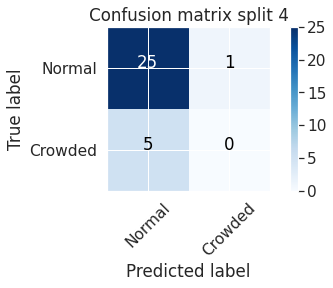

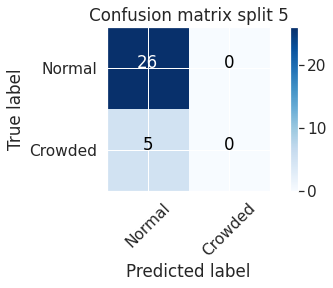

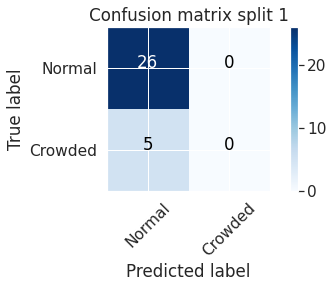

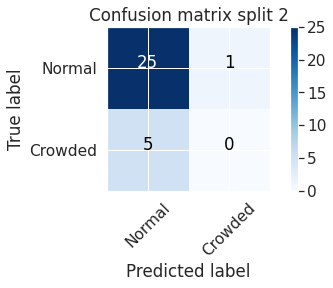

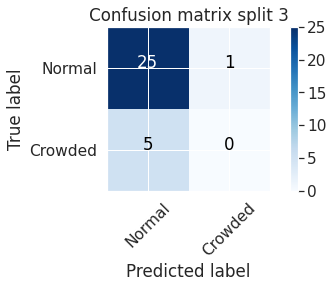

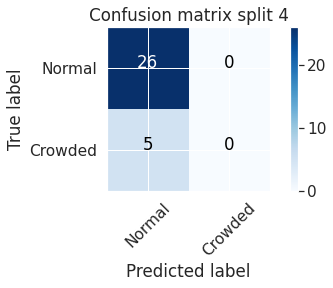

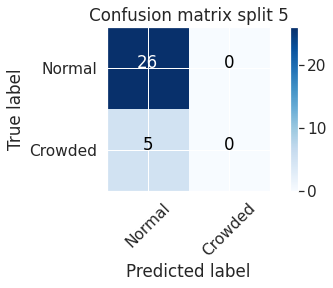

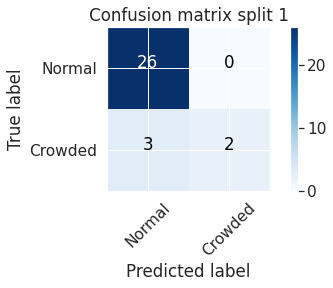

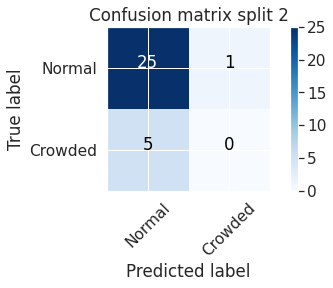

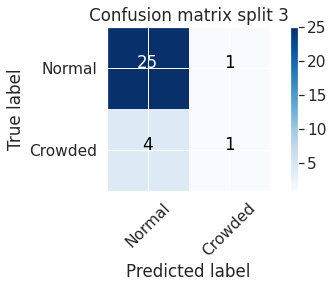

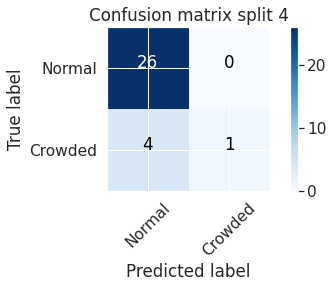

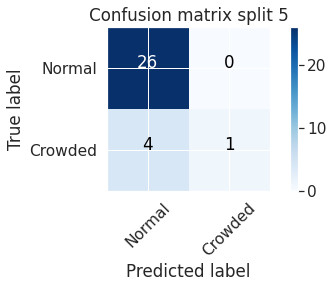

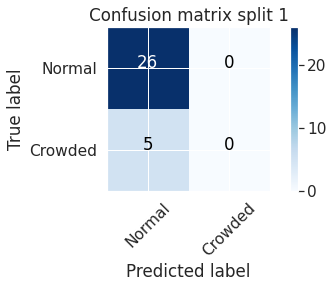

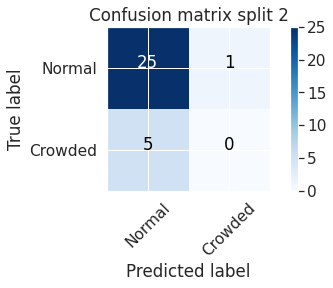

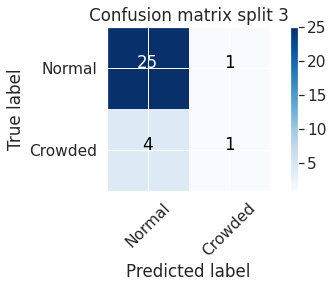

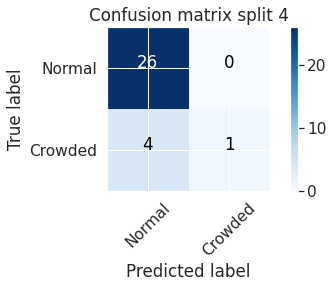

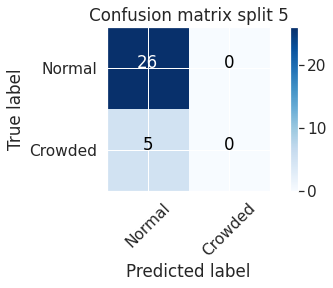

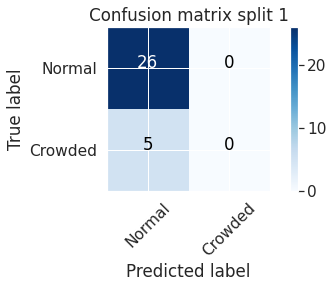

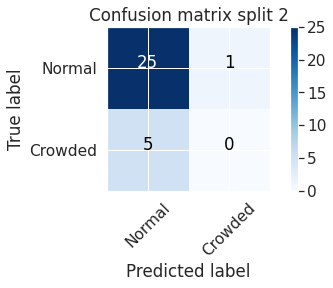

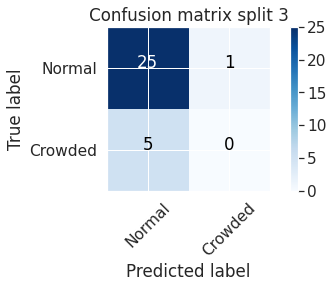

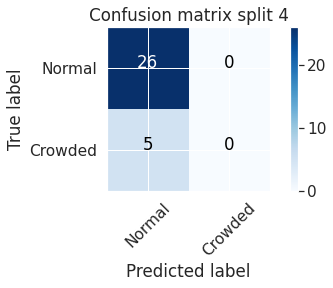

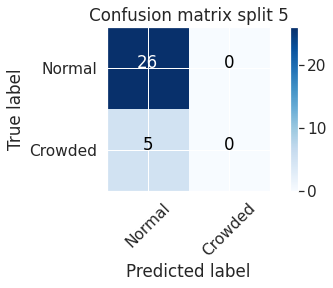

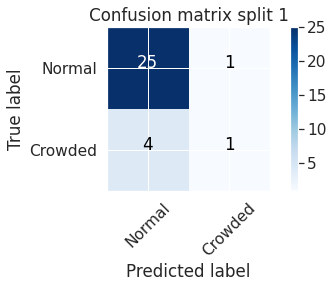

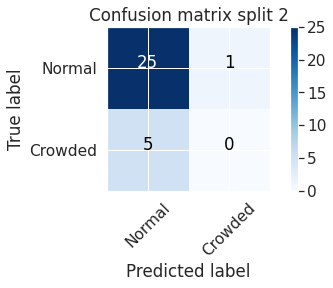

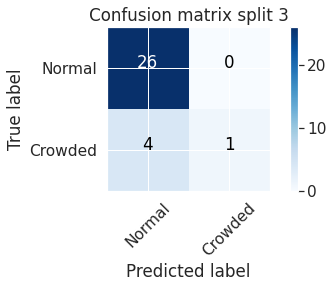

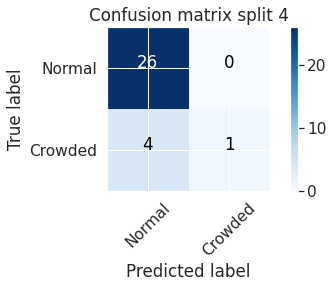

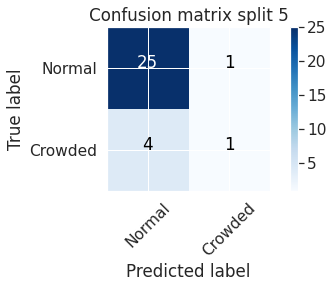

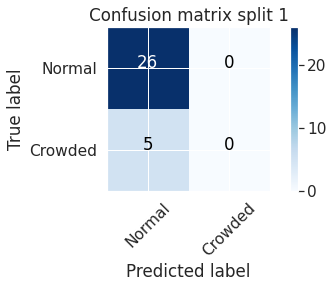

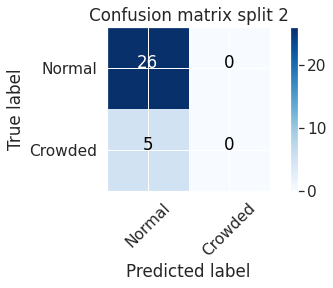

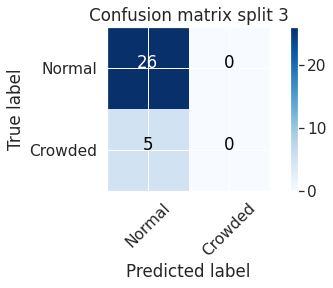

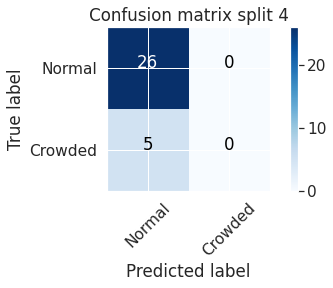

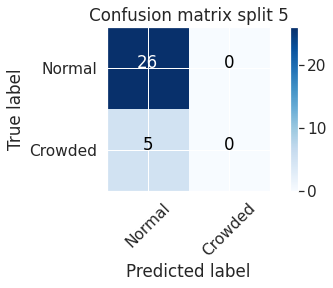

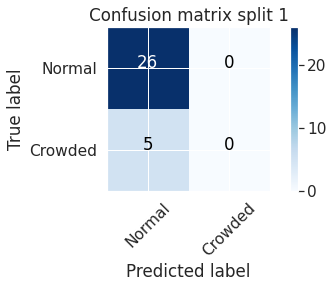

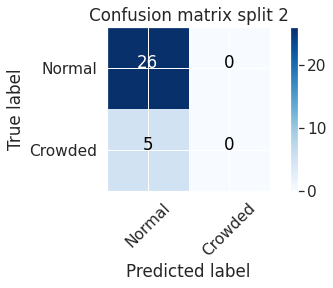

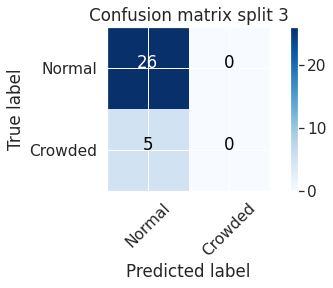

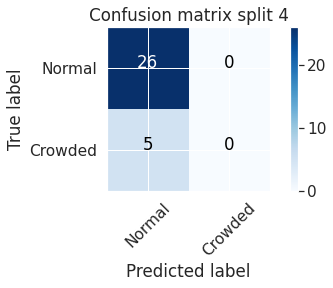

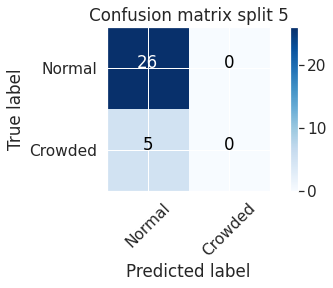

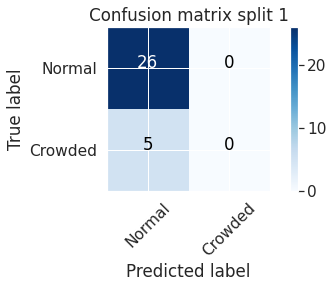

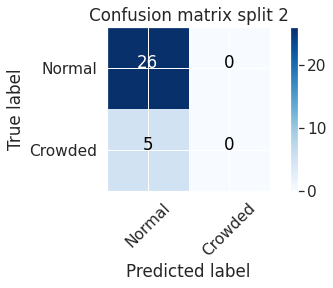

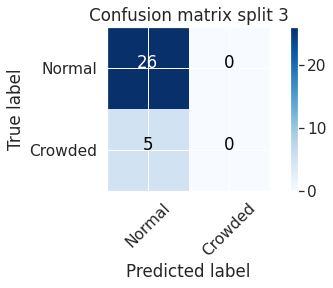

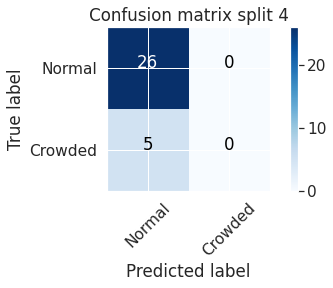

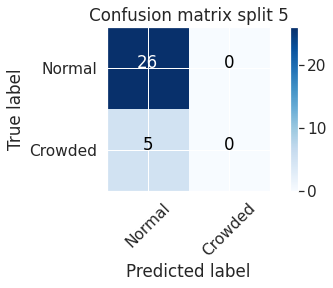

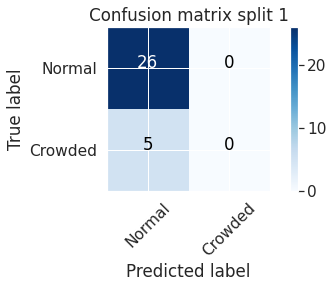

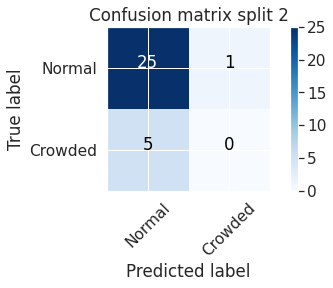

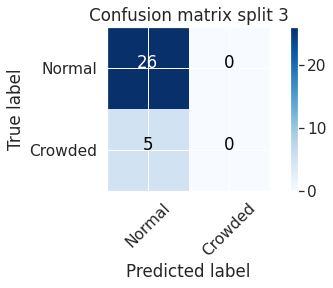

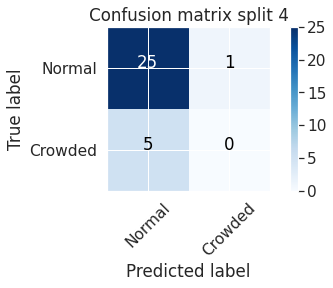

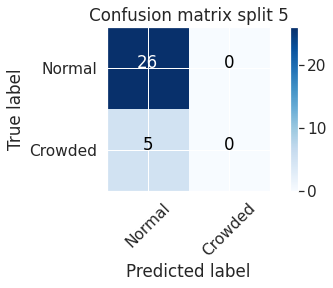

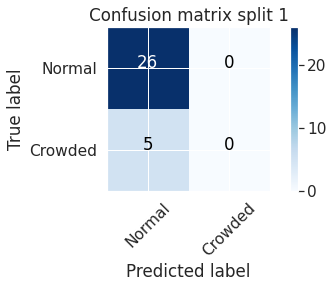

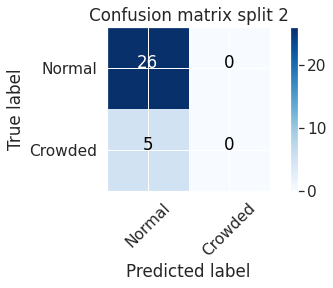

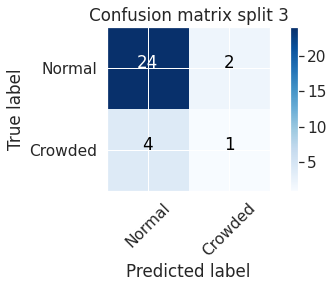

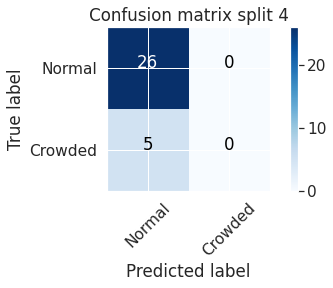

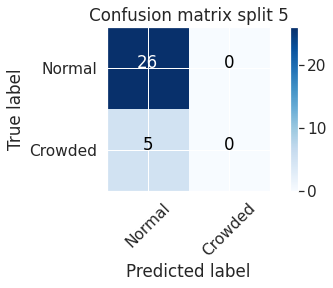

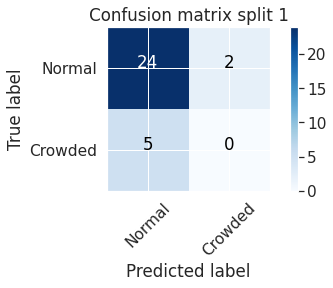

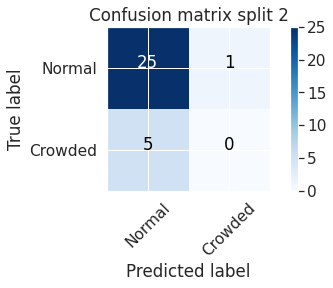

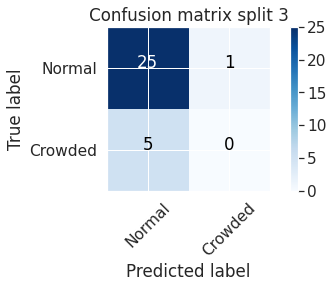

In [44]:
working_dict_balanced = dict_with_frames

for list_type, curr_dict in working_dict_balanced.items():
    current_list = list_names[list_type]
    for k, v in curr_dict.items():
        print(f'Accuracy for {current_list} and {k}:\n')
        create_accuracies(v, str(current_list), str(k))


# Run 3

In [42]:
def plot_confusion_matrix(folder1, folder2,count,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Plots_small/saga/{folder1}/{folder2}/conf_matrix_{count}.png', bbox_inches='tight')



In [43]:
# Second model -> Balanced
def create_accuracies(accur_df, f1, f2):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=22)


    X = accur_df.drop(columns='Crowded').values
    y=accur_df.Crowded.values

    count = 0
    total = 0
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegressionCV(n_jobs=-1)
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        count +=1
#         print(f'Accuracy for split {count}: {acc}')
        total += acc
        cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

        plt.figure()

        plot_confusion_matrix(f1, f2,count,cnf_matrix, classes=['0','1','2','3'],
                          title=f'Confusion matrix split {count}')
    print(total/10)

Accuracy for text and 10:

0.25
Accuracy for text and 30:

0.25
Accuracy for text and 50:

0.225
Accuracy for text and 100:

0.2125
Accuracy for lemmas and 10:

0.25
Accuracy for lemmas and 30:

0.25
Accuracy for lemmas and 50:

0.25
Accuracy for lemmas and 100:

0.23125
Accuracy for entities and 10:

0.23125
Accuracy for entities and 30:

0.225
Accuracy for entities and 50:

0.20625
Accuracy for entities and 100:

0.2375
Accuracy for other and 10:

0.25
Accuracy for other and 30:

0.2375
Accuracy for other and 50:

0.24375
Accuracy for other and 100:

0.2625
Accuracy for all and 10:

0.2375
Accuracy for all and 30:

0.25
Accuracy for all and 50:

0.225
Accuracy for all and 100:



KeyboardInterrupt: 

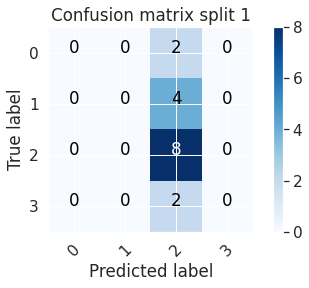

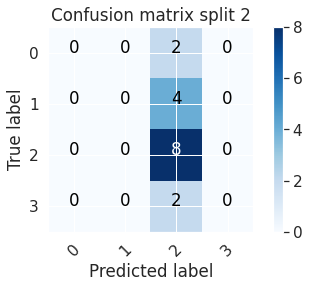

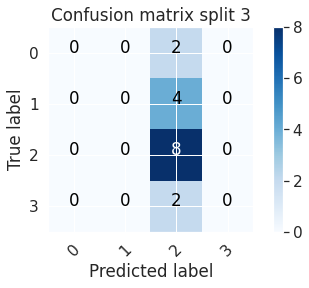

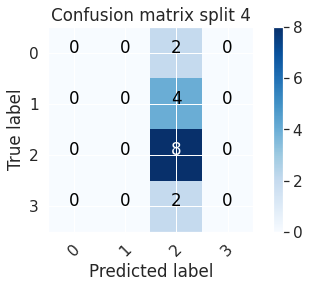

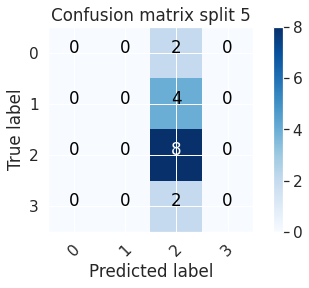

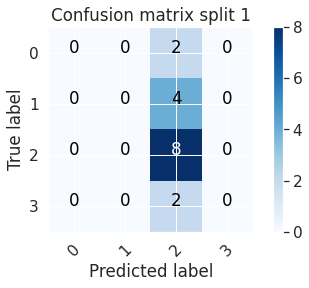

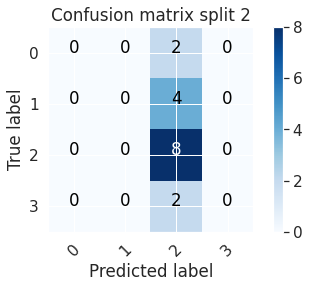

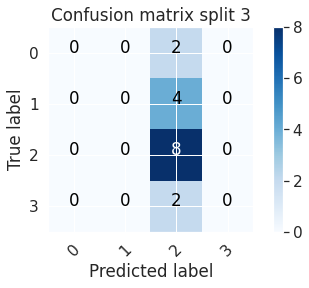

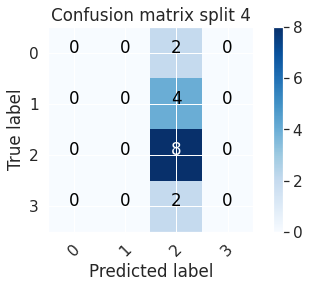

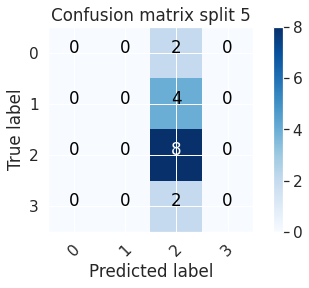

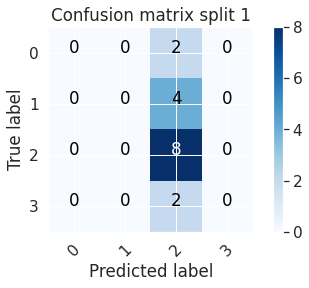

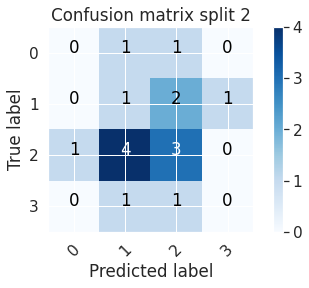

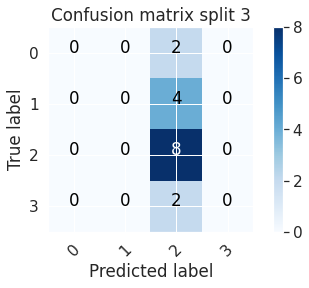

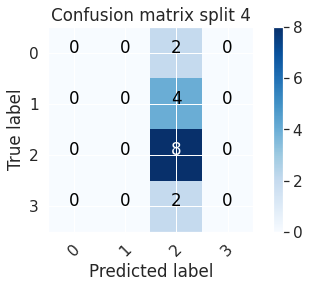

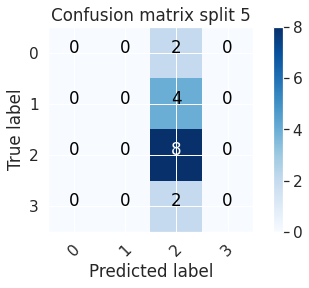

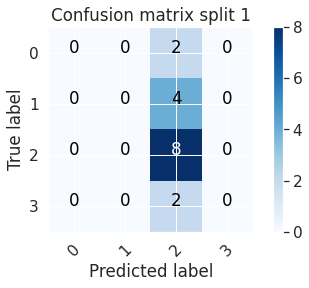

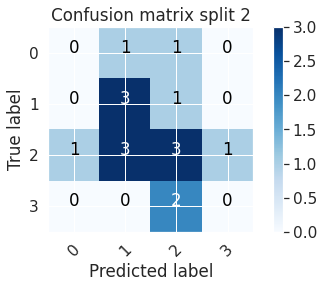

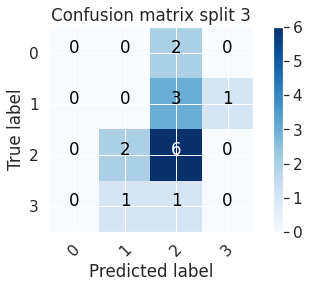

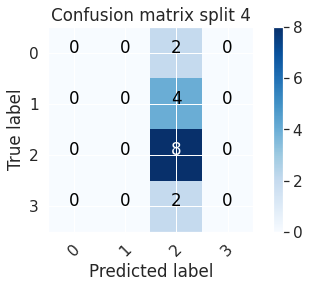

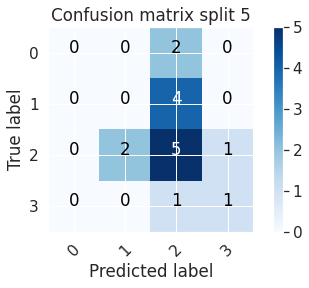

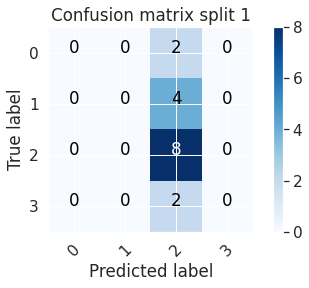

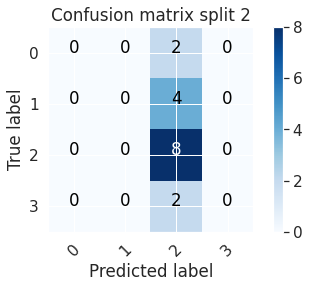

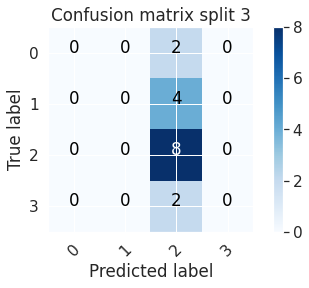

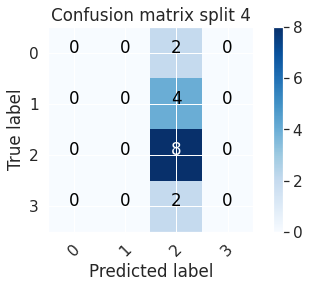

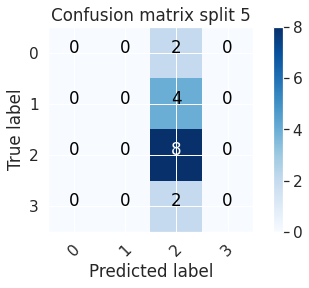

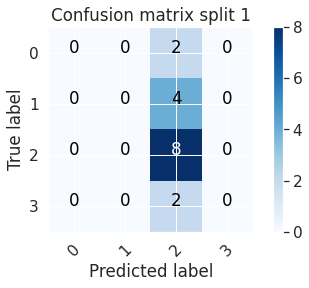

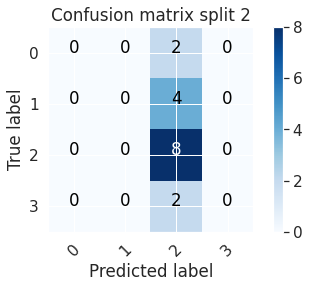

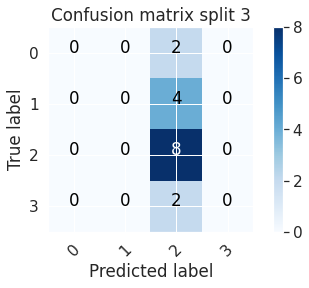

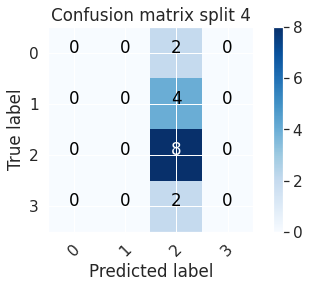

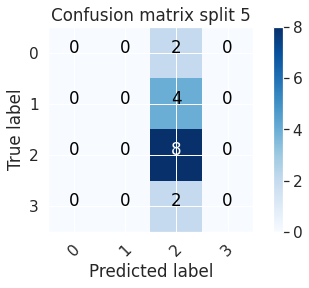

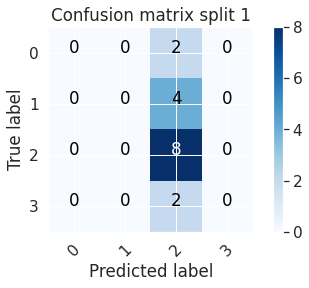

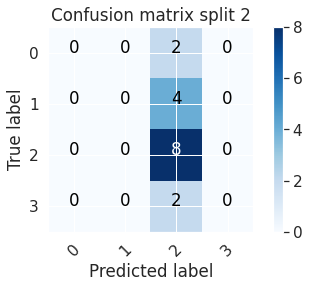

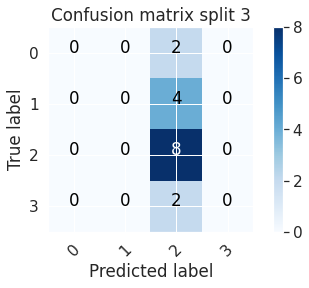

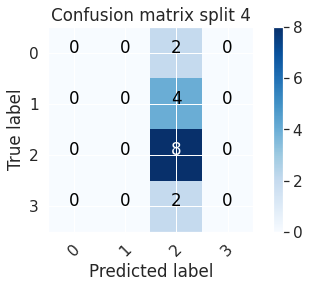

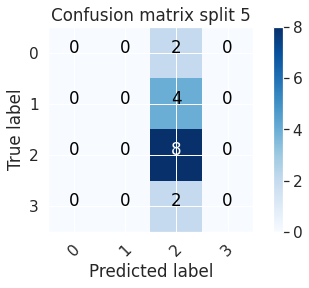

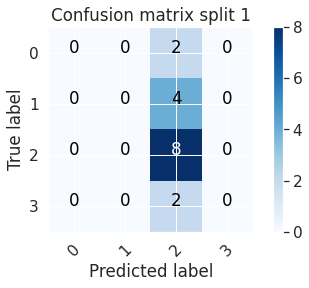

Error in callback <function flush_figures at 0x7f199fad6ca0> (for post_execute):


KeyboardInterrupt: 

In [45]:
working_dict_balanced = dict_with_frames

for list_type, curr_dict in working_dict_balanced.items():
    current_list = list_names[list_type]
    for k, v in curr_dict.items():
        print(f'Accuracy for {current_list} and {k}:\n')
        create_accuracies(v, str(current_list), str(k))


# Run 4

In [ ]:
def plot_confusion_matrix(folder1, folder2,count,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Plots_small/sagal1/{folder1}/{folder2}/conf_matrix_{count}.png', bbox_inches='tight')



In [ ]:
# Second model -> Balanced
def create_accuracies(accur_df, f1, f2):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=22)


    X = accur_df.drop(columns='Crowded').values
    y=accur_df.Crowded.values

    count = 0
    total = 0
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegressionCV(n_jobs=-1, max_iter=300, solver='saga', penalty='l1')
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        count +=1
#         print(f'Accuracy for split {count}: {acc}')
        total += acc
        cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

        plt.figure()

        plot_confusion_matrix(f1, f2,count,cnf_matrix, classes=['0','1','2','3'],
                          title=f'Confusion matrix split {count}')
    print(total/10)

In [ ]:
working_dict_balanced = dict_with_frames

for list_type, curr_dict in working_dict_balanced.items():
    current_list = list_names[list_type]
    for k, v in curr_dict.items():
        print(f'Accuracy for {current_list} and {k}:\n')
        create_accuracies(v, str(current_list), str(k))


# Single models

In [104]:
top_n = 30
new_x = ['lemma', 'hashtags', 'lemma_bigram', 'lemma_trigram', 'ent_date', 'ent_org', 'ent_event', 'ent_person', 'ent_time', 'ent_loc', 'ent_other', 'mentions']
# work with small one for testing purposes
# new_x = ['lemma', 'ent_loc', 'ent_other']
ready_df = pd.DataFrame(dates)

for x in new_x:
    ready_df = ready_df.join(run_all_feature_functions(x, top_n), rsuffix=x)

ready_df.rename(columns={0:'date'}, inplace=True)

combine_df = ready_df.merge(single_location_df,how='outer', on='date')
combine_df = combine_df.dropna()
combine_df = combine_df.reset_index(drop=True)

final_df_full = combine_df.drop(columns='Location')
prediction_df = final_df_full.drop(columns='date')

  (1, 481)	1
  (1, 37)	1
  (1, 725)	1
  (1, 730)	1
  (1, 76)	1
  (1, 58)	1
  (1, 735)	1
  (1, 348)	1
  (1, 721)	1
  (1, 480)	1
  (1, 175)	1
  (1, 471)	1
  (1, 656)	1
  (1, 354)	1
  (1, 875)	1
  (1, 654)	1
  (1, 882)	1
  (1, 692)	1
  (1, 701)	1
  (1, 727)	1
  (1, 583)	1
  (1, 42)	1
  (1, 240)	1
  (1, 85)	1
  (1, 663)	1
  :	:
  (127, 388)	1
  (127, 459)	1
  (127, 267)	1
  (127, 444)	1
  (127, 306)	1
  (127, 904)	1
  (127, 558)	1
  (127, 151)	1
  (127, 278)	1
  (127, 898)	1
  (127, 598)	1
  (127, 868)	1
  (127, 445)	1
  (127, 400)	1
  (127, 185)	1
  (127, 630)	1
  (127, 89)	1
  (127, 544)	1
  (127, 465)	1
  (127, 437)	1
  (127, 716)	1
  (127, 243)	1
  (127, 745)	1
  (127, 520)	1
  (127, 362)	1
  (1, 114)	1
  (3, 571)	1
  (3, 714)	1
  (4, 62)	1
  (5, 1117)	1
  (5, 217)	1
  (5, 247)	1
  (5, 628)	1
  (5, 623)	1
  (5, 962)	1
  (5, 653)	1
  (5, 257)	1
  (5, 234)	1
  (5, 1179)	1
  (5, 956)	1
  (5, 486)	1
  (5, 485)	1
  (5, 91)	1
  (5, 844)	1
  (6, 62)	1
  (6, 91)	1
  (6, 844)	1
  (6, 548)	1
  (

KeyboardInterrupt: 

Accuracy for split 1: 0.5384615384615384
Accuracy for split 2: 0.46153846153846156
Accuracy for split 3: 0.6153846153846154
Accuracy for split 4: 0.5384615384615384
Accuracy for split 5: 0.6153846153846154
Accuracy for split 6: 0.46153846153846156
Accuracy for split 7: 0.46153846153846156
Accuracy for split 8: 0.6153846153846154
Accuracy for split 9: 0.5384615384615384
Accuracy for split 10: 0.3076923076923077
0.5153846153846154


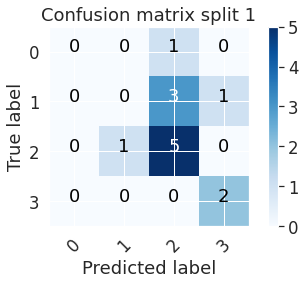

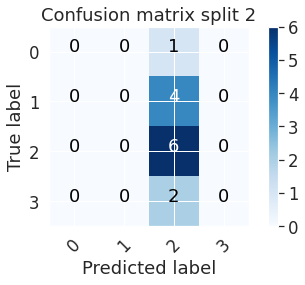

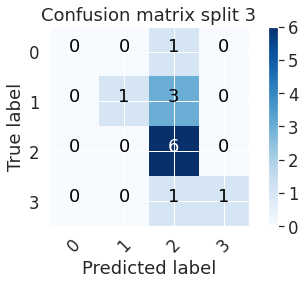

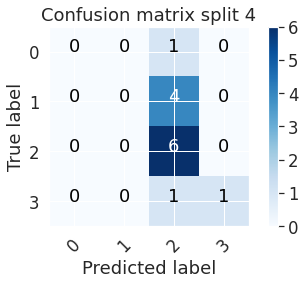

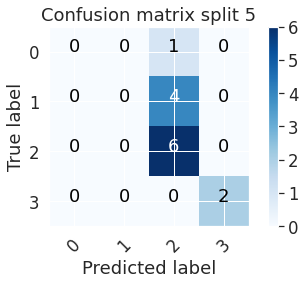

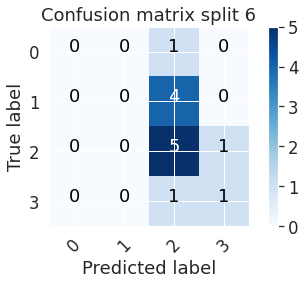

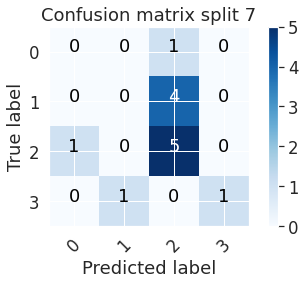

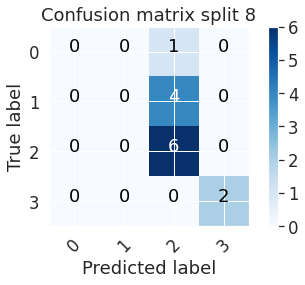

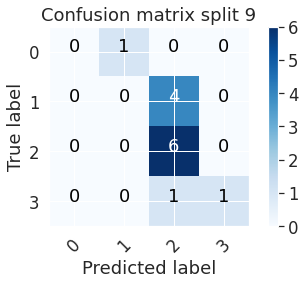

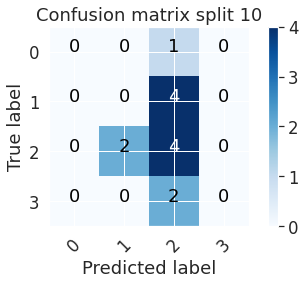

In [43]:
# First model split
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=22)


X = prediction_df.drop(columns='Crowded').values
y=prediction_df.Crowded.values

count = 0
total = 0
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = LogisticRegressionCV(n_jobs=-1)
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count +=1
    print(f'Accuracy for split {count}: {acc}')
    total += acc
    cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

    plt.figure()

    plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3'],
                      title=f'Confusion matrix split {count}')
print(total/10)

In [ ]:
# Second model -> Class weight changes

count = 0
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf2 = LogisticRegressionCV(n_jobs=-1, class_weight='balanced')
    clf2.fit(X_train, y_train)
    train_predictions = clf2.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count +=1
    print(f'Accuracy for split {count}: {acc}')
    cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

    plt.figure()

    plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3'],
                      title=f'Confusion matrix split {count}')


In [ ]:
# Third model -> Stratified K Fold
skf = StratifiedKFold(n_splits=10)


X = prediction_df.drop(columns='Crowded').values
y=prediction_df.Crowded.values

count = 0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = LogisticRegressionCV(n_jobs=-1)
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count +=1
    print(f'Accuracy for split {count}: {acc}')
    cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

    plt.figure()

    plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3'],
                      title=f'Confusion matrix split {count}')


In [ ]:
# Fourth model -> Stratified K Fold with balanced
skf = StratifiedKFold(n_splits=10)


X = prediction_df.drop(columns='Crowded').values
y=prediction_df.Crowded.values

count = 0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = LogisticRegressionCV(n_jobs=-1, class_weight='balanced')
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count +=1
    print(f'Accuracy for split {count}: {acc}')
    cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

    plt.figure()

    plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3'],
                      title=f'Confusion matrix split {count}')


In [ ]:
# Fith model -> Stratified K Fold with shuffle
skf = StratifiedKFold(n_splits=10, random_state=22, shuffle=True)


X = prediction_df.drop(columns='Crowded').values
y=prediction_df.Crowded.values

count = 0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = LogisticRegressionCV(n_jobs=-1)
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count +=1
    print(f'Accuracy for split {count}: {acc}')
    cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

    plt.figure()

    plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3'],
                      title=f'Confusion matrix split {count}')


In [ ]:
# Sixth model -> Stratified K Fold with shuffle with balanced
skf = StratifiedKFold(n_splits=10, random_state=22, shuffle=True)


X = prediction_df.drop(columns='Crowded').values
y=prediction_df.Crowded.values

count = 0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = LogisticRegressionCV(n_jobs=-1, class_weight='balanced')
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count +=1
    print(f'Accuracy for split {count}: {acc}')
    cnf_matrix = metrics.confusion_matrix(y_test, train_predictions)

    plt.figure()

    plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3'],
                      title=f'Confusion matrix split {count}')


In [ ]:
clf.score(X, y)

In [ ]:

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

plot_cv_indicesices(sss, X, y, )

In [ ]:
# Evenly spaced groups repeated once
groups = np.hstack([[ii] for ii in range(122)])


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_',
               lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)),  [3.5] * len(groups), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[.5, 3.5],
           yticklabels=['Data\ngroup', 'Data\nclass'], xlabel="Sample index")


visualize_groups(y, groups, 'no groups')

In [ ]:
cv = ShuffleSplit



this_cv = cv(n_splits=n_splits)
fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=.7)
plt.show()

# Tweede ronde
Hier wordt alles berekend voor 7 losse dagen

In [ ]:
# Create a list of most frequent words for a certain column
def create_values_range_2(mygroup, feature):
    
    daily_ht = [text for text in mygroup[f'{feature}']]
    daily_freq = nltk.FreqDist(sum(daily_ht, [])).most_common(top_n)
    values = [i[0] for i in daily_freq]
    
    return values

# In this function the data is gathered for 1 day, 3 days and 7 days before the actual date.
def create_all_features_2(date, my_df, feature):
    
    frampies = []
    for i in range(1,8):
#         Create a variable that makes the previous day
        temp_date = date - datetime.timedelta(days=i)
        frampies.append(my_df.loc[my_df['date'] == temp_date])

#     Send the aquired tweets for the daterange to the function that returns a list of most common words for the send feature
    most_common_list1 = create_values_range_2(frampies[0], feature)
    most_common_list2 = create_values_range_2(frampies[1], feature)
    most_common_list3 = create_values_range_2(frampies[2], feature)
    most_common_list4 = create_values_range_2(frampies[3], feature)
    most_common_list5 = create_values_range_2(frampies[4], feature)
    most_common_list6 = create_values_range_2(frampies[5], feature)
    most_common_list7 = create_values_range_2(frampies[6], feature)
    temp_dict = {'day1':most_common_list1,'day2':most_common_list2,'day3':most_common_list3,'day4':most_common_list4,'day5':most_common_list5,'day6':most_common_list6,'day7':most_common_list7}
    
    return temp_dict

# Loop over the dates for each feature
def run_single_feature_2(feature):
    
    my_dict = {}

    for date in dates:
        my_dict[date] = create_all_features_2(date, local_tweet_df, feature)
    return my_dict


In [ ]:
def create_string(mylist):
    return ' '.join(mylist)
    
def create_columns(feature):
    temp_corpus = tweet_[f'{feature}'].apply(create_string).to_list()
    return temp_corpus


In [ ]:
# Create the corpus plus BoW for each feature
def run_all_feature_functions_2(feature):
    tmp_corpus = create_columns(feature)
    my_dict = run_single_feature_2(feature)
    
    token_docs = [doc.split() for doc in tmp_corpus]
    all_tokens = set([word for sentence in token_docs for word in sentence])
    word_to_idx = {token:idx+1 for idx, token in enumerate(all_tokens)}
    day1 = []
    day2 = []
    day3 = []
    day4 = []
    day5 = []
    day6 = []
    day7 = []
    for key, value in my_dict.items():
    
        day1.append(create_string(value['day1']))
        day2.append(create_string(value['day2']))
        day3.append(create_string(value['day3']))
        day4.append(create_string(value['day4']))
        day5.append(create_string(value['day5']))
        day6.append(create_string(value['day6']))
        day7.append(create_string(value['day7']))
    
    bow = CountVectorizer().fit(tmp_corpus)
    
    bow_day1 = bow.fit_transform(day1)
    bow_day2 = bow.fit_transform(day2)
    bow_day3 = bow.fit_transform(day3)
    bow_day4 = bow.fit_transform(day4)
    bow_day5 = bow.fit_transform(day5)
    bow_day6 = bow.fit_transform(day6)
    bow_day7 = bow.fit_transform(day7)
    
    
    # converting to dataframe
    print(bow_day1)
#     df1 = pd.DataFrame(bow_day1.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day1')
    df2 = pd.DataFrame(bow_day2.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day2')
    df3 = pd.DataFrame(bow_day3.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day3')
    df4 = pd.DataFrame(bow_day4.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day4')
    df5 = pd.DataFrame(bow_day5.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day5')
    df6 = pd.DataFrame(bow_day6.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day6')
    df7 = pd.DataFrame(bow_day7.toarray(), columns=sorted(bow.vocabulary_)).add_suffix('_day7')
    

    tmp_f_df = df1.join(df2)
    tmp_f_df = tmp_f_df.join(df3)
    tmp_f_df = tmp_f_df.join(df4)
    tmp_f_df = tmp_f_df.join(df5)
    tmp_f_df = tmp_f_df.join(df6)
    tmp_f_df = tmp_f_df.join(df7)
    return tmp_f_df


In [ ]:
fix_columns_df_2 = tweet_df
top_n = 30
all_cols = []

# all_cols.append(['lemma', 'lemma_bigram', 'lemma_trigram'])
# all_cols.append(['ent_date', 'ent_org', 'ent_event', 'ent_person', 'ent_time', 'ent_loc', 'ent_other'])
# all_cols.append(['hashtags', 'mentions'])
# all_cols.append(['lemma', 'hashtags', 'lemma_bigram', 'lemma_trigram', 'ent_date', 'ent_org', 'ent_event', 'ent_person', 'ent_time', 'ent_loc', 'ent_other', 'mentions'])

# model_1_cols = ['lemma', 'lemma_bigram', 'lemma_trigram']
# model_2_cols = ['ent_date', 'ent_org', 'ent_event', 'ent_person', 'ent_time', 'ent_loc', 'ent_other']
# model_3_cols = ['hashtags', 'mentions']
combined_cols = ['lemma', 'hashtags', 'lemma_bigram', 'lemma_trigram', 'ent_date', 'ent_org', 'ent_event', 'ent_person', 'ent_time', 'ent_loc', 'ent_other', 'mentions']

ready_df2 = pd.DataFrame(dates)

# for x in cols:
for x in combined_cols:
    ready_df2 = ready_df2.join(run_all_feature_functions_2(x), rsuffix=x)

ready_df2.rename(columns={0:'date'}, inplace=True)

ready_df2

In [ ]:
# Make dataframe ready for the prediction

prediction_df = combine_df.drop(columns='Location')

X_train, X_test, y_train, y_test = train_test_split(prediction_df.drop('Crowded',axis=1), 
                                                prediction_df['Crowded'], test_size=0.30, 
                                                random_state=44)  



X_train

In [ ]:
# Create logistic regression model
logmodel = LogisticRegression()
train_dup = X_train
print(train_dup.shape, X_train.shape)
X_train = X_train.drop(columns='date')
validate_dup = X_test
print(validate_dup.shape, X_test.shape)

X_test = X_test.drop(columns='date')

logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

print(logmodel.score(X_train, y_train))

y_pred = logmodel.predict(X_test)
print((logmodel.score(X_test, y_test)))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# ?
y_pred = [int(i) for i in y_pred]

print(list(y_pred))
print(y_test.tolist())

In [ ]:
final_train = train_dup['date'].reset_index()
final_train.drop(columns='index', inplace=True)
final_train['crowdednes'] = y_train
final_train.dropna(inplace=True)
final_train

In [ ]:
final_test = validate_dup['date'].reset_index()
final_test.drop(columns='index', inplace=True)
final_test['crowdednes'] = y_test


final_test

In [ ]:
final_test = validate_dup['date'].reset_index()
final_test.drop(columns='index', inplace=True)
final_test['crowdednes'] = y_test
final_test.dropna(inplace=True)
final_test

In [ ]:
final_pred = validate_dup['date'].reset_index()
final_pred.drop(columns='index', inplace=True)
final_pred['crowdednes'] = y_pred
final_pred.dropna(inplace=True)
final_test

In [ ]:
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="time")

-----------------------------------------------------
# EVERYTHING BELOW IS NOT YET IMPLEMENTED
--------------------------------------------------------

# Feature X: Tweet LDA or TF-IDF



In [ ]:
STOP

In [ ]:
all_words = []
for words in lda_df['lemma_lower']:
    if len(words) > 0:
        all_words.extend(words)
    
print(len(all_words))
tweet_lengths = [len(tokens) for tokens in lda_df['lemma_lower']]
vocab = sorted(list(set(all_words)))
print(vocab[0:100])
print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

In [ ]:
lda_df.info()

In [ ]:
id2word = Dictionary(lda_df['lemma'])
print(len(id2word))


In [ ]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

In [ ]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in lda_df['lemma']]


In [ ]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [ ]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [ ]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [ ]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

In [ ]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=lda_df['lemma'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)

In [ ]:
#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in lda_df['lemma'] for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(30)

In [ ]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

In [ ]:
from wordcloud import WordCloud

#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')

plt.show()

# Feature X: Tweet visibility / Reach
<a id="feature3"></a>
How many people have effectively seen or interacted with the tweet? If a tweet is retweeted, it brings a lot more visibility.
Improved version of tweet frequency?

### [Back To Table of Contents](#top_section)

In [ ]:
# clean_tweets_df = tweet_df[['uniqueid', 'stopwords_removed','like_cnt', 'rply_cnt']]

# Feature X: Previous day crowd

This will be the crowdedness of the day before. This could learn the model, that some trends will keep being active, even after the event itself as people will be discussing the event but it will not lead to a new one. 
Uitleggen nabespreking van een evenement


In [ ]:
def get_crowd_prev_day(row):
    date = row['date']
    

# Feature X: Corona indicator
Gives a score to the corona situation with regard to rules etc

# Feature X: Weather
Add an indication of the weather (temperature + neerslag).
Might be to strong and pulling away the attention from the tweets. 